In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sci
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_excel('Capstone Project.xlsx')
df.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   

   strength  
0     29.89  
1     23.51  
2     29.22  
3     45.85  
4     18.29

In [7]:
df.shape

(1030, 9)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


In [13]:
df.describe()

cement         slag          ash        water  superplastic  \
count  1030.000000  1030.000000  1030.000000  1030.000000   1030.000000   
mean    281.167864    73.895825    54.188350   181.567282      6.204660   
std     104.506364    86.279342    63.997004    21.354219      5.973841   
min     102.000000     0.000000     0.000000   121.800000      0.000000   
25%     192.375000     0.000000     0.000000   164.900000      0.000000   
50%     272.900000    22.000000     0.000000   185.000000      6.400000   
75%     350.000000   142.950000   118.300000   192.000000     10.200000   
max     540.000000   359.400000   200.100000   247.000000     32.200000   

         coarseagg      fineagg          age     strength  
count  1030.000000  1030.000000  1030.000000  1030.000000  
mean    972.918932   773.580485    45.662136    35.817961  
std      77.753954    80.175980    63.169912    16.705742  
min     801.000000   594.000000     1.000000     2.330000  
25%     932.000000   730.950000     7.000000    23.710000  
50%     968.000000   779.500000    28.000000    34.445000  
75%    1029.400000   824.000000    56.000000    46.135000  
max    1145.000000   992.600000   365.000000    82.600000

In [15]:
def custom_summary(my_df):
    result = []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            stats = OrderedDict({
                'Feature Name': col , 
                'Count': my_df[col].count() ,
                'Minimum': my_df[col].min() ,
                'Quartile1': my_df[col].quantile(.25) ,
                'Quartile2': my_df[col].quantile(.50) ,
                'Mean': my_df[col].mean() ,
                'Quartile 3': my_df[col].quantile(.75) ,
                'Maximum': my_df[col].max() ,
                'Variance': round(my_df[col].var()) ,
                'Standard Deviation': my_df[col].std() ,
                'Skewness': my_df[col].skew() , 
                'Kurtosis': my_df[col].kurt()
                })
            result.append(stats)
    result_df = pd.DataFrame(result)
    #Skewness type: 
    skewness_label = []
    for i in result_df['Skewness']:
        if i <= -1:
            skewness_label.append('Highly Negatively Skewed')
        elif -1 < i <= -0.5:
            skewness_label.append('Moderately Negatively Skewed')
        elif -0.5 < i < 0:
            skewness_label.append('Fairly Negatively Skewed')
        elif 0 <= i < 0.5:
            skewness_label.append('Fairly Positively Skewed')
        elif 0.5 <= i < 1:
            skewness_label.append('Moderately Positively Skewed')
        elif i >= 1:
            skewness_label.append('Highly Positively Skewed')
    result_df['Skewness Comment'] = skewness_label
    kurtosis_label = []
    for i in result_df['Kurtosis']:
        if i >= 1:
            kurtosis_label.append('Leptokurtic Curve')
        elif i <= -1:
            kurtosis_label.append('Platykurtic Curve')
        else:
            kurtosis_label.append('Mesokurtic Curve')
    result_df['Kurtosis Comment'] = kurtosis_label
    Outliers_label = []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            Q1 = my_df[col].quantile(0.25)
            Q2 = my_df[col].quantile(0.5)
            Q3 = my_df[col].quantile(0.75)
            IQR = Q3 - Q1
            LW = Q1 - 1.5*IQR
            UW = Q3 + 1.5*IQR
            if len(my_df[(my_df[col] < LW) | (my_df[col] > UW)]) > 0:
                Outliers_label.append('Have Outliers')
            else:
                Outliers_label.append('No Outliers')
    result_df['Outlier Comment'] = Outliers_label

            
    return result_df

In [17]:
custom_summary(df)

Feature Name  Count  Minimum  Quartile1  Quartile2        Mean  Quartile 3  \
0        cement   1030   102.00    192.375    272.900  281.167864     350.000   
1          slag   1030     0.00      0.000     22.000   73.895825     142.950   
2           ash   1030     0.00      0.000      0.000   54.188350     118.300   
3         water   1030   121.80    164.900    185.000  181.567282     192.000   
4  superplastic   1030     0.00      0.000      6.400    6.204660      10.200   
5     coarseagg   1030   801.00    932.000    968.000  972.918932    1029.400   
6       fineagg   1030   594.00    730.950    779.500  773.580485     824.000   
7           age   1030     1.00      7.000     28.000   45.662136      56.000   
8      strength   1030     2.33     23.710     34.445   35.817961      46.135   

   Maximum  Variance  Standard Deviation  Skewness   Kurtosis  \
0    540.0     10922          104.506364  0.509481  -0.520652   
1    359.4      7444           86.279342  0.800717  -0.508175   
2    200.1      4096           63.997004  0.537354  -1.328746   
3    247.0       456           21.354219  0.074628   0.122082   
4     32.2        36            5.973841  0.907203   1.411269   
5   1145.0      6046           77.753954 -0.040220  -0.599016   
6    992.6      6428           80.175980 -0.253010  -0.102177   
7    365.0      3990           63.169912  3.269177  12.168989   
8     82.6       279           16.705742  0.416977  -0.313725   

               Skewness Comment   Kurtosis Comment Outlier Comment  
0  Moderately Positively Skewed   Mesokurtic Curve     No Outliers  
1  Moderately Positively Skewed   Mesokurtic Curve   Have Outliers  
2  Moderately Positively Skewed  Platykurtic Curve     No Outliers  
3      Fairly Positively Skewed   Mesokurtic Curve   Have Outliers  
4  Moderately Positively Skewed  Leptokurtic Curve   Have Outliers  
5      Fairly Negatively Skewed   Mesokurtic Curve     No Outliers  
6      Fairly Negatively Skewed   Mesokurtic Curve   Have Outliers  
7      Highly Positively Skewed  Leptokurtic Curve   Have Outliers  
8      Fairly Positively Skewed   Mesokurtic Curve   Have Outliers

Performing outlier Treatment

In [20]:
def replace_outlier(my_df , col , method = 'Quartile' , strategy = 'Median'):
    col_data = my_df[col] #method means how are you supposed to detect the outliers.
    
    
    if method == 'Quartile':
        #Using quartiles to calculate IQR
        q1 = col_data.quantile(0.25)
        q2 = col_data.quantile(0.5)
        q3 = col_data.quantile(0.75)

        IQR = q3 - q1
        LW = q1 - 1.5*IQR
        UW = q3 + 1.5*IQR
        
    elif method == 'Standard Deviation': #we are using empirical method here 
        mean = col_data.mean()
        std = col_data.std()
        LW = mean - 2*std
        UW = mean + 2*std
    else:
        print('Pass a correct method')
    
    #printing all the outliers
    
    outliers =  my_df.loc[(col_data < LW) | (col_data > UW)]
    outlier_density = round(len(outliers)/len(my_df) , 2) * 100 #What i am doing is, i am checking how many percentage of records are there which are outlier, so lets say if i have 15% are outliers so 15 % is my outliers density.
    if len(outliers) == 0:
        print(f'Feature {col} doesnot have any outliers')
        print('\n') #\n means next line
    else:
        print(f'Feature {col} Has outliers')
        print('\n')
        print(f'Total number of outliers in {col} are {len(outliers)}')
        print('\n')
        print(f'outlier percentage in {col} is {outlier_density}%')
        print('\n')
        display(my_df[(col_data < LW) | (col_data > UW)])
        
    #Replacing outliers 
    if strategy == 'Median':
        my_df.loc[(col_data < LW) | (col_data > UW) , col] = q2
    elif strategy == 'Mean':
         my_df.loc[(col_data < LW) | (col_data > UW) , col] = mean
    else:
        print('pass a correct strategy')
        
        
    return my_df

In [24]:
def odt_plots(my_df, col):
    f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (25,8))
    
    #Descriptive stats boxplot
    sns.boxplot(my_df[col], ax = ax1)
    ax1.set_title(col + 'Boxplot')
    ax1.set_xlabel('values')
    ax1.set_ylabel('Boxplot')
    
    #Plotting Histogram with outliers
    sns.distplot(my_df[col], ax= ax2, fit = sci.norm)
    ax2.axvline(my_df[col].mean(), color = 'green')
    ax2.axvline(my_df[col].median(), color = 'brown')
    ax2.set_title(col + 'Histogram with Outliers')
    ax2.set_ylabel('Density')
    ax2.set_xlabel('values')
    
    #Replacing outliers
    df_out = replace_outlier(my_df, col)
    
    
    #Plotting histogram without outliers
    sns.distplot(df_out[col], ax = ax3, fit = sci.norm) #on histogram we are fiiting normal distribution plot
    ax3.axvline(df_out[col].mean(), color = 'green')
    ax3.axvline(df_out[col].median(), color = 'brown')
    ax3.set_title(col + 'Histogram without Outliers')
    ax3.set_ylabel('Density')
    ax3.set_xlabel('values')
    plt.show()

In [26]:
df.columns

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'strength'],
      dtype='object')

Feature cement doesnot have any outliers




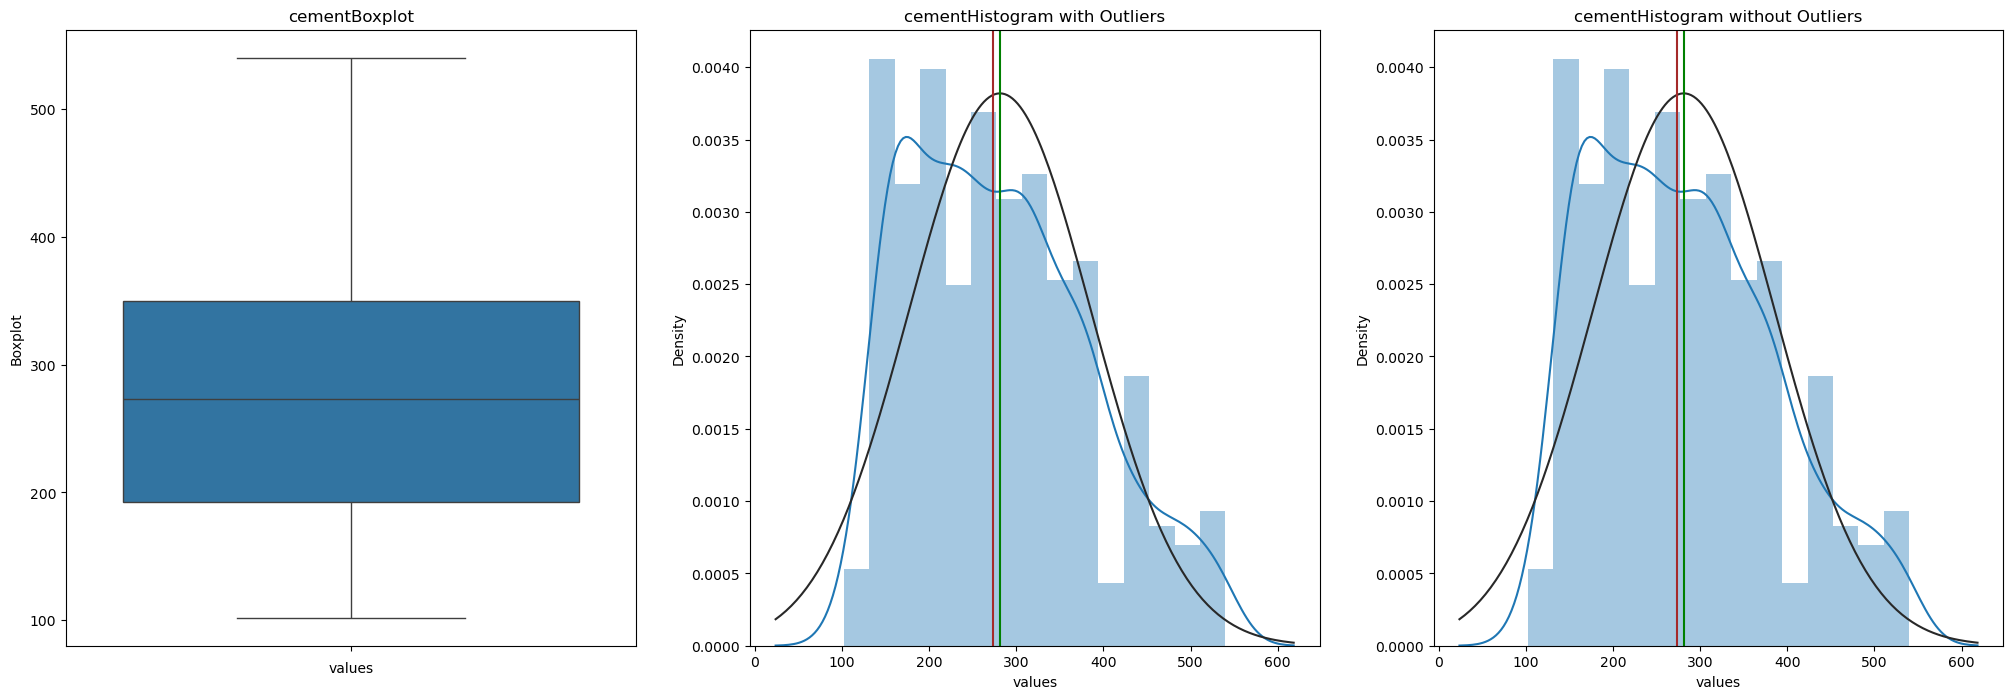

Feature slag Has outliers


Total number of outliers in slag are 2


outlier percentage in slag is 0.0%




cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
918   239.6  359.4  0.0  185.7           0.0      941.6    664.3   28   
990   239.6  359.4  0.0  185.7           0.0      941.6    664.3    7   

     strength  
918     39.44  
990     25.42

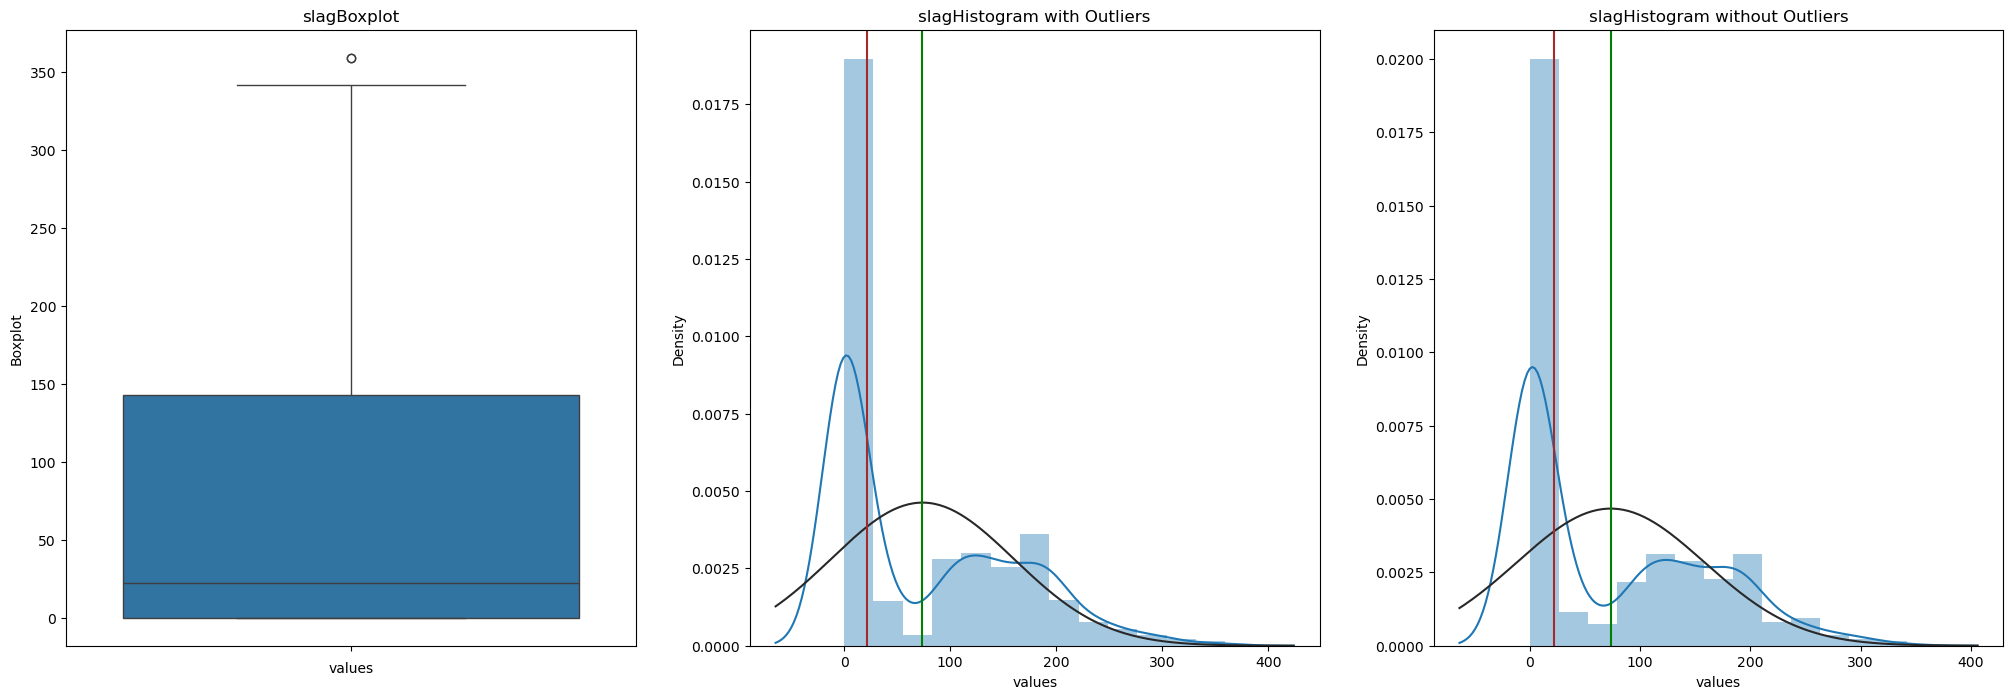

Feature ash doesnot have any outliers




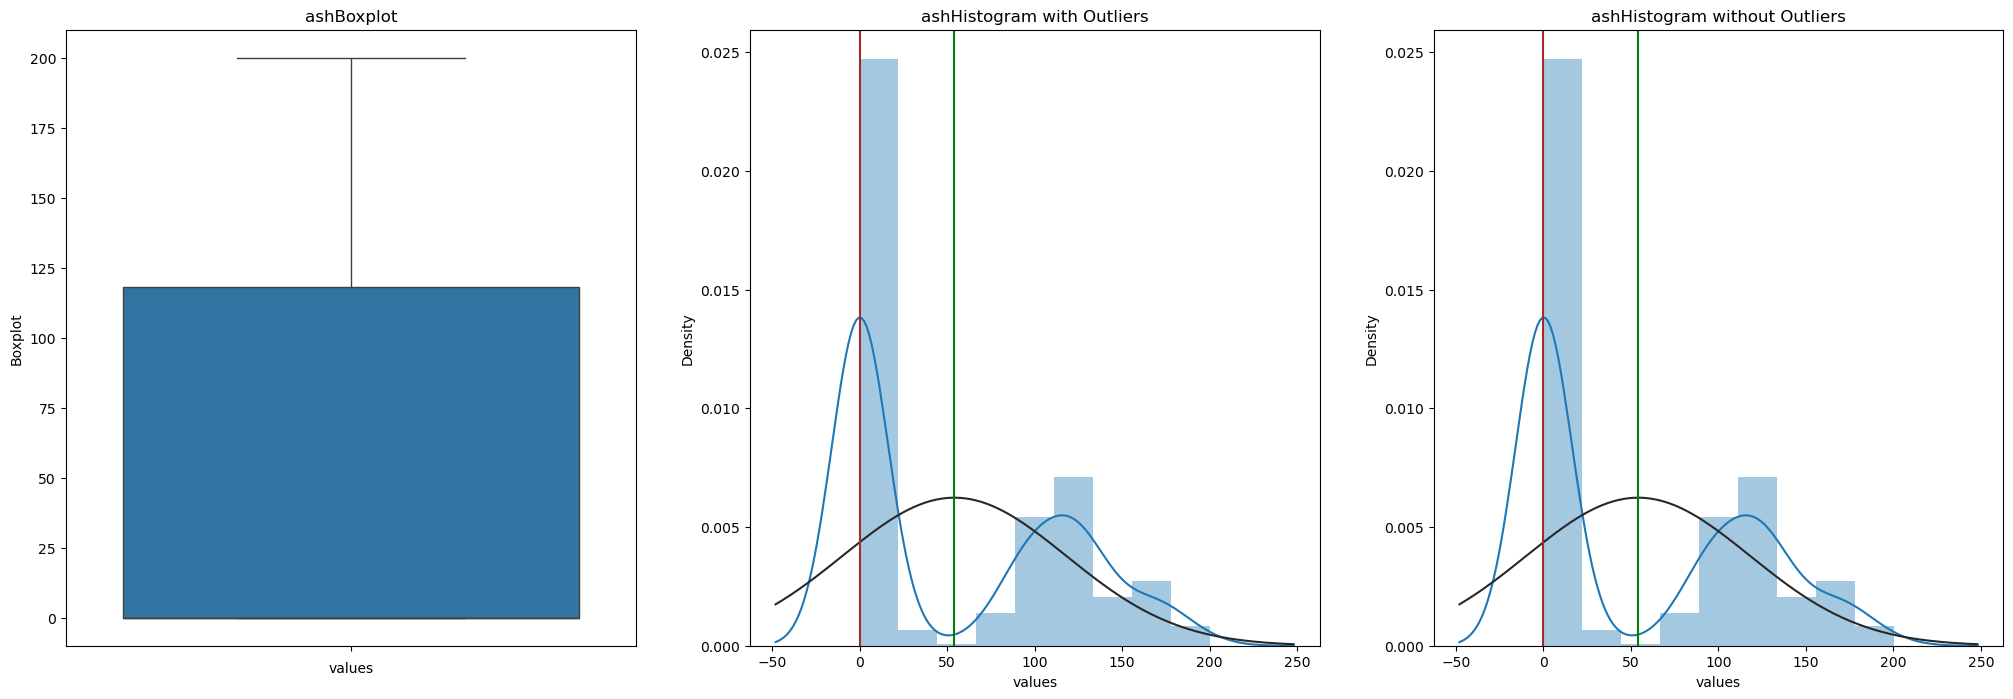

Feature water Has outliers


Total number of outliers in water are 9


outlier percentage in water is 1.0%




cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
66    237.0   92.0   71.0  247.0           6.0      853.0    695.0   28   
263   236.9   91.7   71.5  246.9           6.0      852.9    695.4   28   
432   168.0   42.1  163.8  121.8           5.7     1058.7    780.1   28   
462   168.0   42.1  163.8  121.8           5.7     1058.7    780.1  100   
587   168.0   42.1  163.8  121.8           5.7     1058.7    780.1    3   
740   140.0  164.0  128.0  237.0           6.0      869.0    656.0   28   
789   168.0   42.1  163.8  121.8           5.7     1058.7    780.1   56   
826   139.7  163.9  127.7  236.7           5.8      868.6    655.6   28   
914   168.0   42.1  163.8  121.8           5.7     1058.7    780.1   14   

     strength  
66      28.63  
263     28.63  
432     24.24  
462     39.23  
587      7.75  
740     35.23  
789     32.85  
826     35.23  
914     17.82

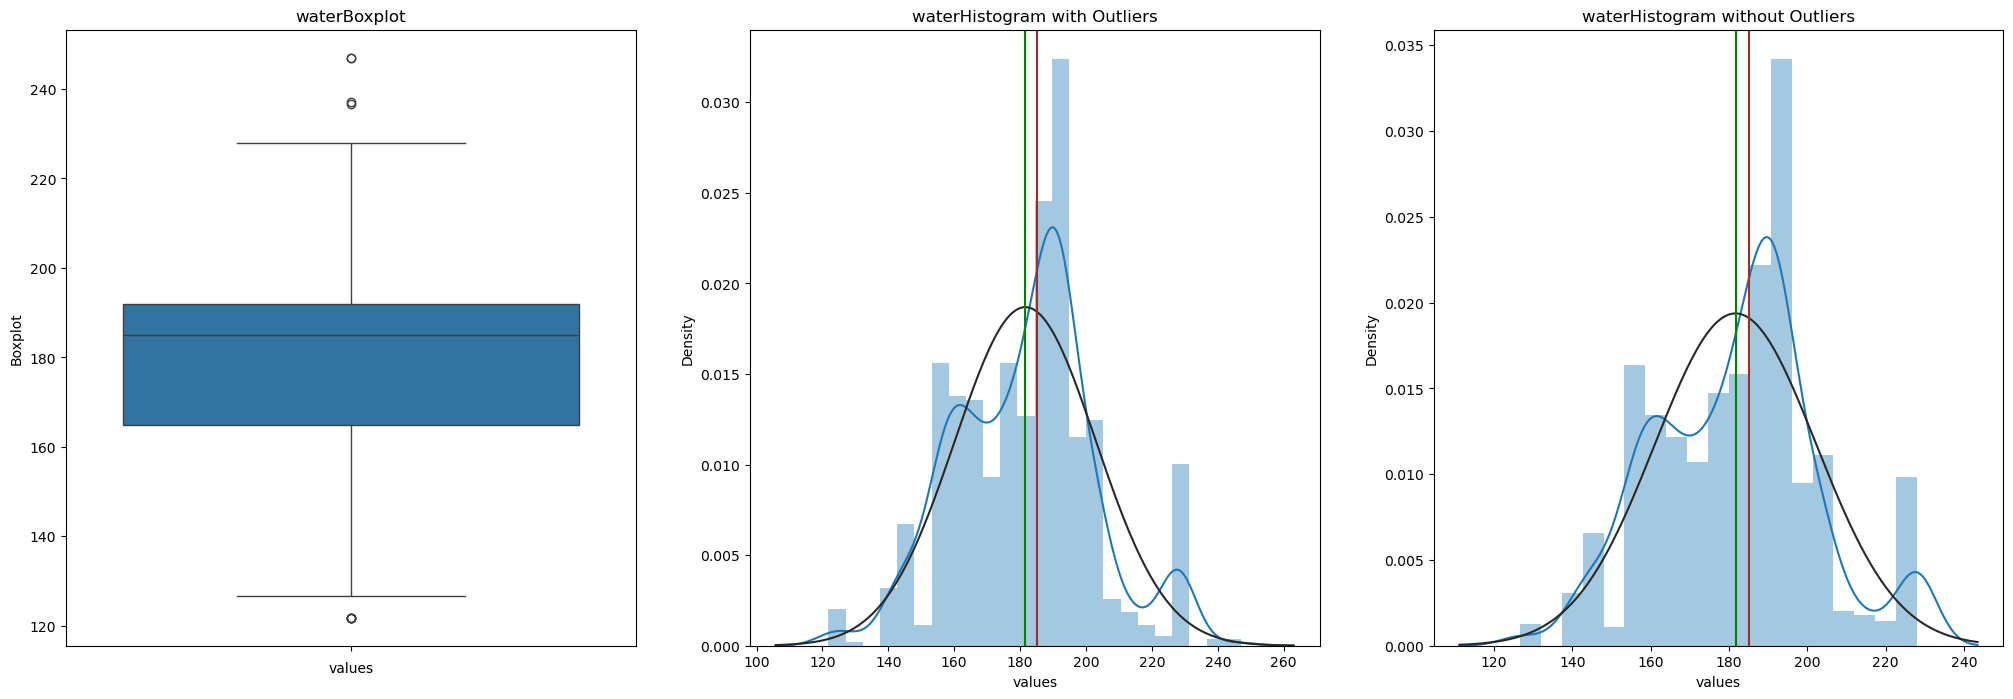

Feature superplastic Has outliers


Total number of outliers in superplastic are 10


outlier percentage in superplastic is 1.0%




cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
44     531.3    0.0  0.0  141.8          28.2      852.1    893.7   91   
156    531.3    0.0  0.0  141.8          28.2      852.1    893.7   28   
232    469.0  117.2  0.0  137.8          32.2      852.1    840.5   56   
292    469.0  117.2  0.0  137.8          32.2      852.1    840.5   91   
538    531.3    0.0  0.0  141.8          28.2      852.1    893.7    7   
744    469.0  117.2  0.0  137.8          32.2      852.1    840.5    7   
816    469.0  117.2  0.0  137.8          32.2      852.1    840.5   28   
838    531.3    0.0  0.0  141.8          28.2      852.1    893.7   56   
955    469.0  117.2  0.0  137.8          32.2      852.1    840.5    3   
1026   531.3    0.0  0.0  141.8          28.2      852.1    893.7    3   

      strength  
44        59.2  
156       56.4  
232       69.3  
292       70.7  
538       46.9  
744       54.9  
816       66.9  
838       58.8  
955       40.2  
1026      41.3

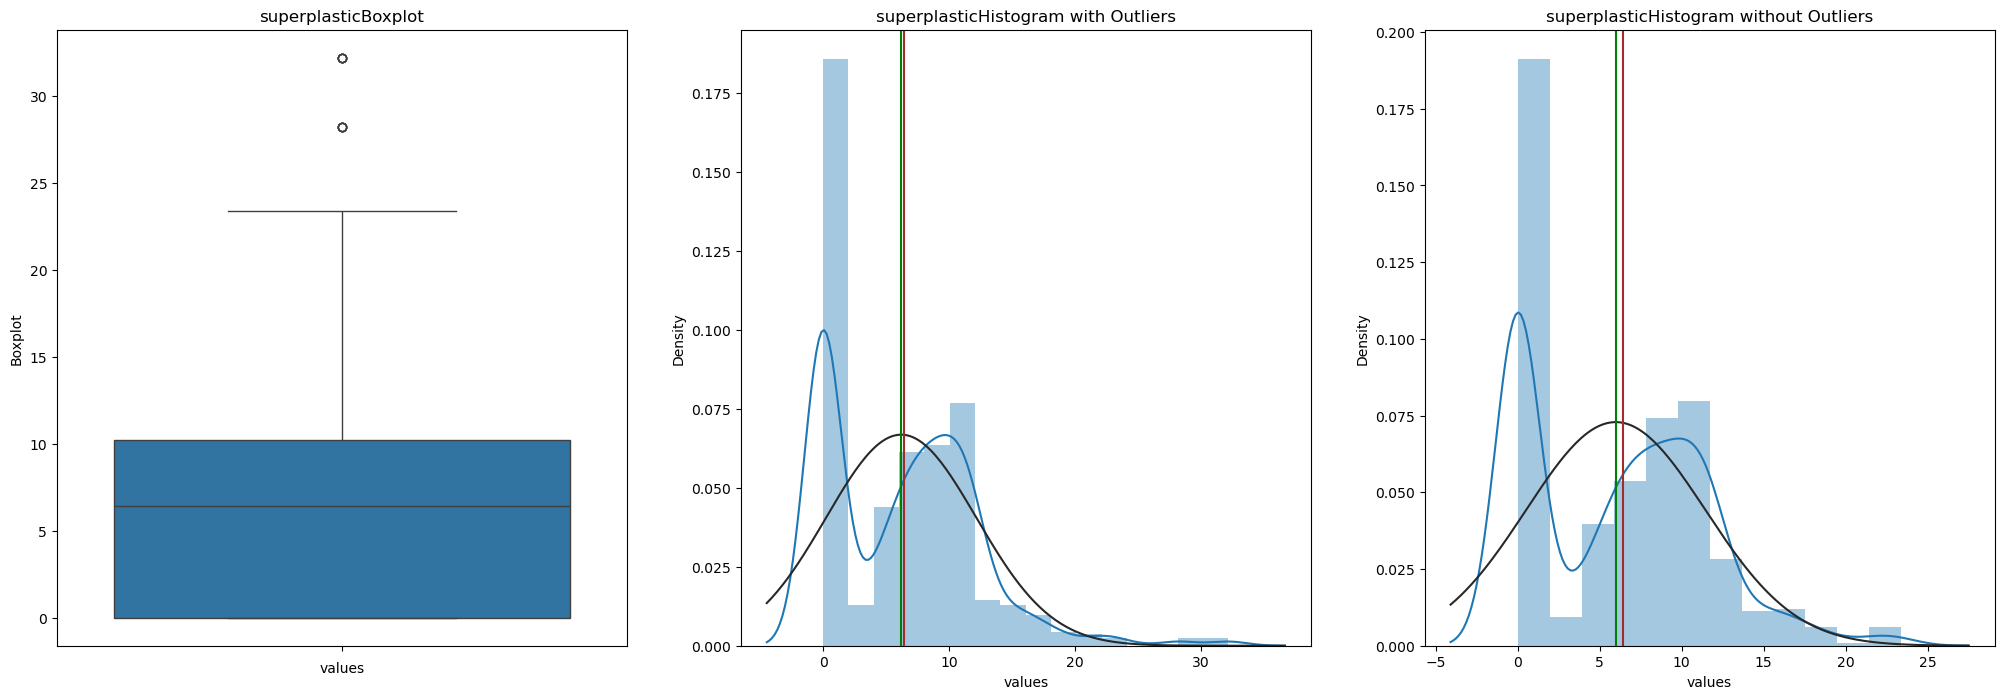

Feature coarseagg doesnot have any outliers




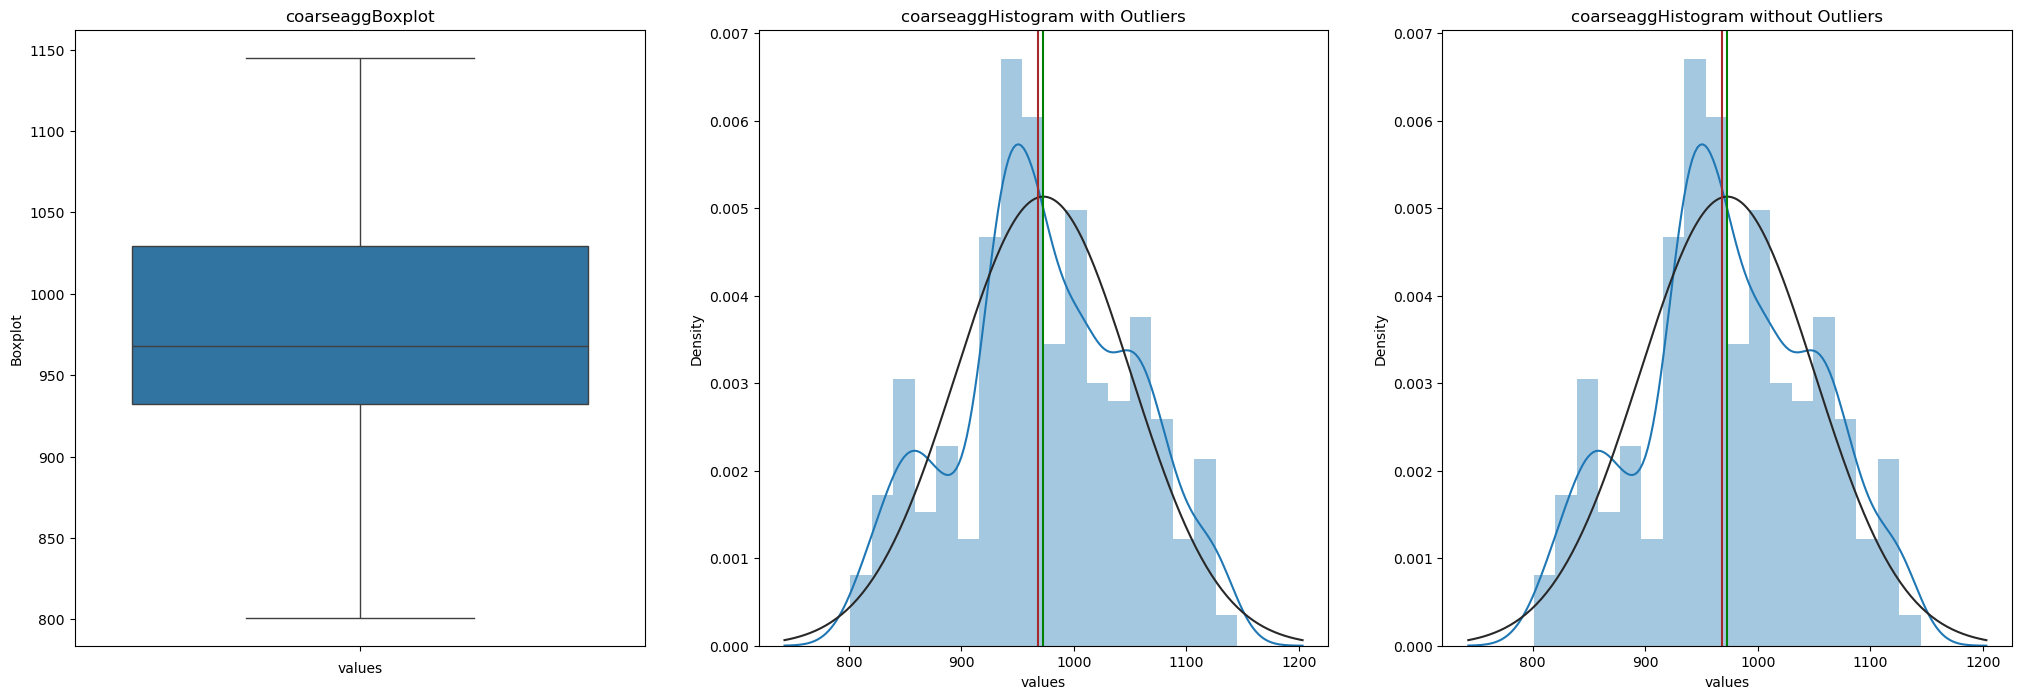

Feature fineagg Has outliers


Total number of outliers in fineagg are 5


outlier percentage in fineagg is 0.0%




cement  slag  ash  water  superplastic  coarseagg  fineagg  age  strength
129   375.0  93.8  0.0  126.6          23.4      852.1    992.6   91      62.5
447   375.0  93.8  0.0  126.6          23.4      852.1    992.6    7      45.7
504   375.0  93.8  0.0  126.6          23.4      852.1    992.6    3      29.0
584   375.0  93.8  0.0  126.6          23.4      852.1    992.6   56      60.2
857   375.0  93.8  0.0  126.6          23.4      852.1    992.6   28      56.7

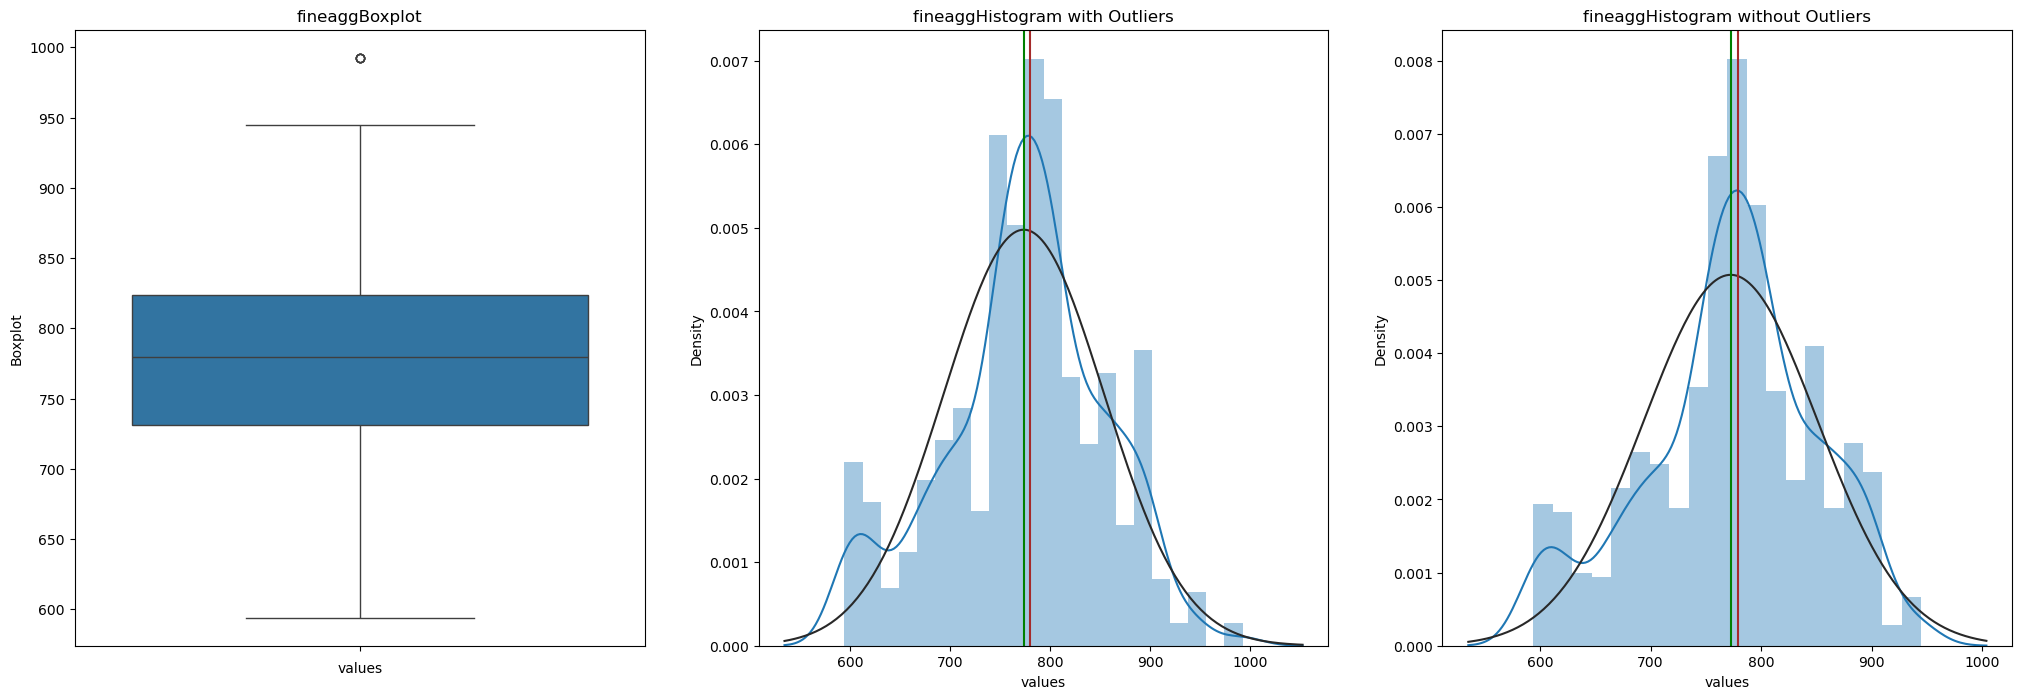

Feature age Has outliers


Total number of outliers in age are 59


outlier percentage in age is 6.0%




cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
51     331.0    0.0  0.0  192.0           0.0      978.0    825.0  180   
64     332.5  142.5  0.0  228.0           0.0      932.0    594.0  365   
93     427.5   47.5  0.0  228.0           0.0      932.0    594.0  180   
99     237.5  237.5  0.0  228.0           0.0      932.0    594.0  180   
103    380.0    0.0  0.0  228.0           0.0      932.0    670.0  180   
133    236.0    0.0  0.0  193.0           0.0      968.0    885.0  365   
144    302.0    0.0  0.0  203.0           0.0      974.0    817.0  180   
149    380.0   95.0  0.0  228.0           0.0      932.0    594.0  270   
152    322.0    0.0  0.0  203.0           0.0      974.0    800.0  180   
157    198.6  132.4  0.0  192.0           0.0      978.4    825.5  360   
159    304.0   76.0  0.0  228.0           0.0      932.0    670.0  365   
198    266.0  114.0  0.0  228.0           0.0      932.0    670.0  365   
199    277.0    0.0  0.0  191.0           0.0      968.0    856.0  180   
207    190.0  190.0  0.0  228.0           0.0      932.0    670.0  180   
256    525.0    0.0  0.0  189.0           0.0     1125.0    613.0  270   
262    266.0  114.0  0.0  228.0           0.0      932.0    670.0  270   
270    500.0    0.0  0.0  200.0           0.0     1125.0    613.0  270   
297    475.0    0.0  0.0  228.0           0.0      932.0    594.0  270   
302    342.0   38.0  0.0  228.0           0.0      932.0    670.0  180   
312    236.0    0.0  0.0  193.0           0.0      968.0    885.0  180   
313    540.0    0.0  0.0  173.0           0.0     1125.0    613.0  270   
323    139.6  209.4  0.0  192.0           0.0     1047.0    806.9  360   
359    475.0    0.0  0.0  228.0           0.0      932.0    594.0  180   
361    277.0    0.0  0.0  191.0           0.0      968.0    856.0  360   
370    266.0  114.0  0.0  228.0           0.0      932.0    670.0  180   
393    342.0   38.0  0.0  228.0           0.0      932.0    670.0  365   
448    331.0    0.0  0.0  192.0           0.0      978.0    825.0  360   
465    427.5   47.5  0.0  228.0           0.0      932.0    594.0  365   
484    237.5  237.5  0.0  228.0           0.0      932.0    594.0  365   
539    304.0   76.0  0.0  228.0           0.0      932.0    670.0  180   
570    190.0  190.0  0.0  228.0           0.0      932.0    670.0  270   
581    525.0    0.0  0.0  189.0           0.0     1125.0    613.0  180   
594    339.0    0.0  0.0  197.0           0.0      968.0    781.0  180   
601    339.0    0.0  0.0  197.0           0.0      968.0    781.0  365   
620    332.5  142.5  0.0  228.0           0.0      932.0    594.0  180   
622    380.0   95.0  0.0  228.0           0.0      932.0    594.0  180   
623    380.0    0.0  0.0  228.0           0.0      932.0    670.0  270   
632    304.0   76.0  0.0  228.0           0.0      932.0    670.0  270   
642    198.6  132.4  0.0  192.0           0.0      978.4    825.5  180   
696    307.0    0.0  0.0  193.0           0.0      968.0    812.0  180   
713    190.0  190.0  0.0  228.0           0.0      932.0    670.0  365   
720    380.0   95.0  0.0  228.0           0.0      932.0    594.0  365   
721    500.0    0.0  0.0  200.0           0.0     1125.0    613.0  180   
754    254.0    0.0  0.0  198.0           0.0      968.0    863.0  365   
755    349.0    0.0  0.0  192.0           0.0     1047.0    806.0  360   
776    540.0    0.0  0.0  173.0           0.0     1125.0    613.0  180   
850    427.5   47.5  0.0  228.0           0.0      932.0    594.0  270   
861    310.0    0.0  0.0  192.0           0.0      970.0    850.0  180   
878    237.5  237.5  0.0  228.0           0.0      932.0    594.0  270   
900    254.0    0.0  0.0  198.0           0.0      968.0    863.0  180   
901    475.0    0.0  0.0  228.0           0.0      932.0    594.0  365   
919    310.0    0.0  0.0  192.0           0.0      970.0    850.0  360   
951    332.5  142.5  0.0  228.0           0.0      932.0    594.0  270   
957    307

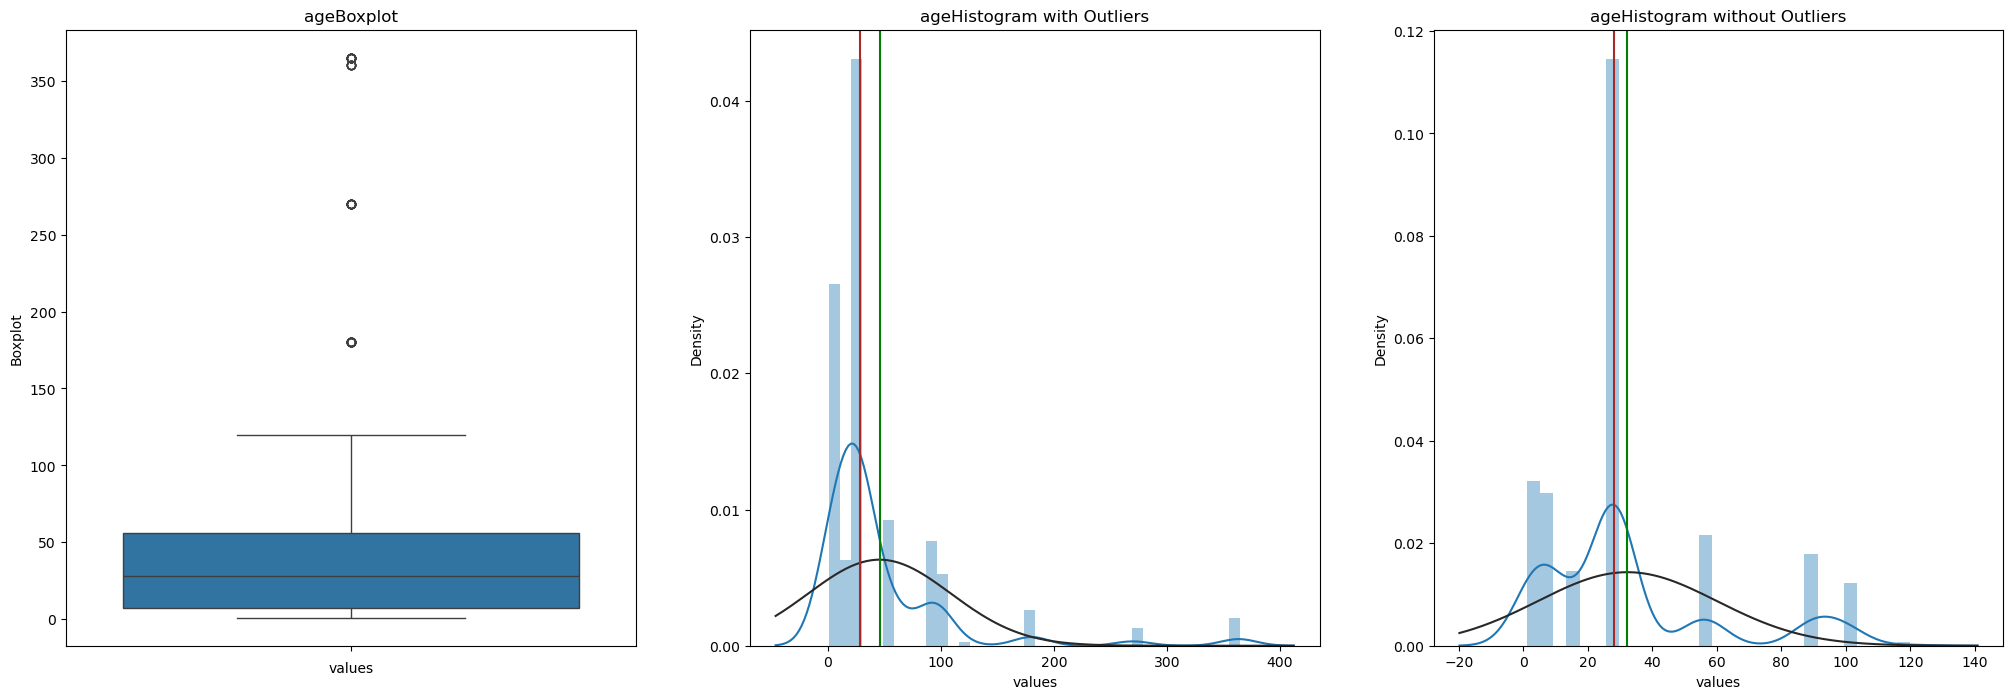

Feature strength Has outliers


Total number of outliers in strength are 4


outlier percentage in strength is 0.0%




cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
192    315.0  137.0  0.0  145.0           5.9     1130.0    745.0   28   
732    540.0    0.0  0.0  162.0           2.5     1040.0    676.0   28   
950    389.9  189.0  0.0  145.9          22.0      944.7    755.8   91   
1003   323.7  282.8  0.0  183.8          10.3      942.7    659.9   56   

      strength  
192      81.75  
732      79.99  
950      82.60  
1003     80.20

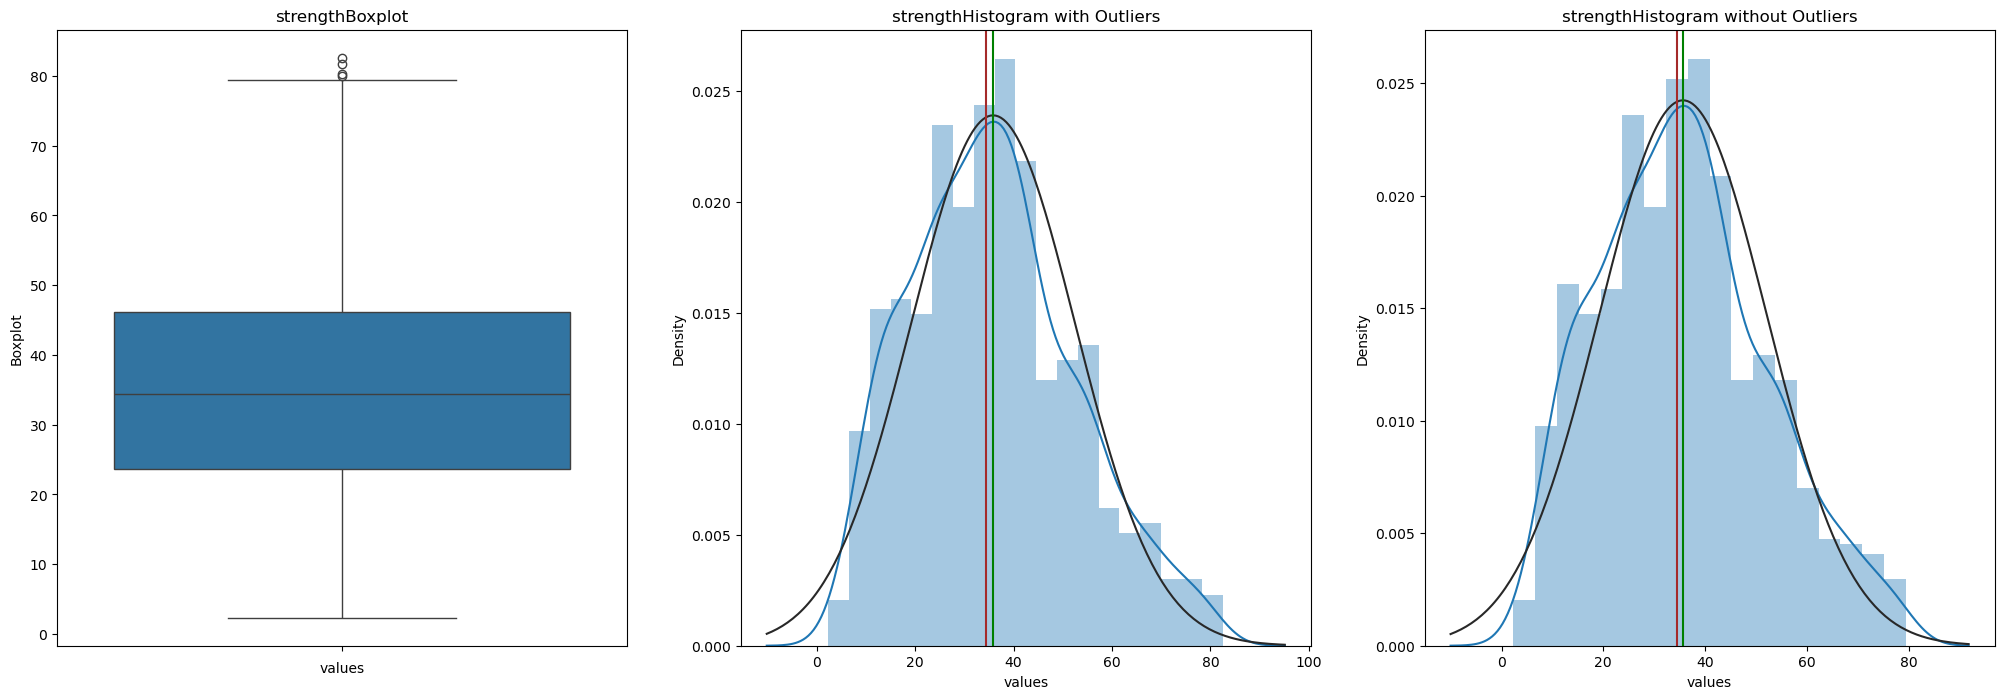

In [28]:
for col in df.columns:
    odt_plots(df,col)

Multivariate Analysis Using Regression

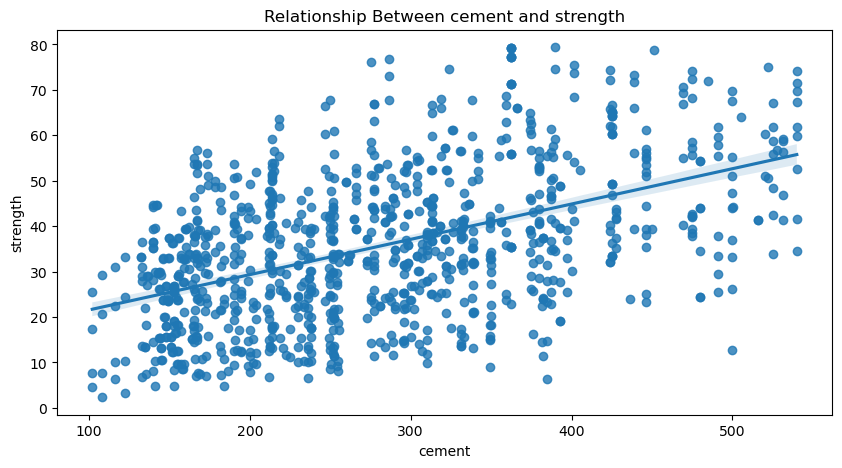

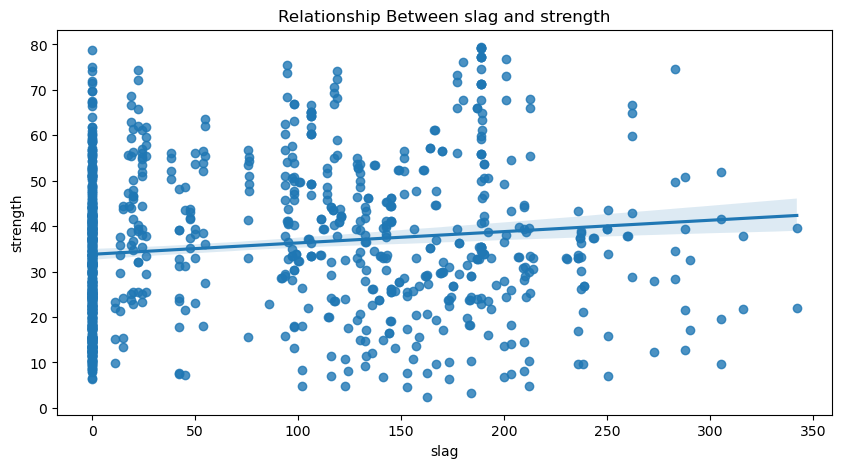

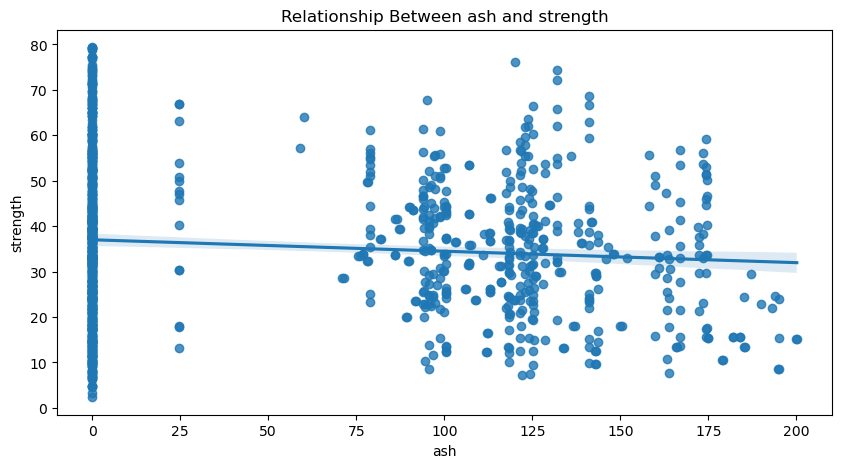

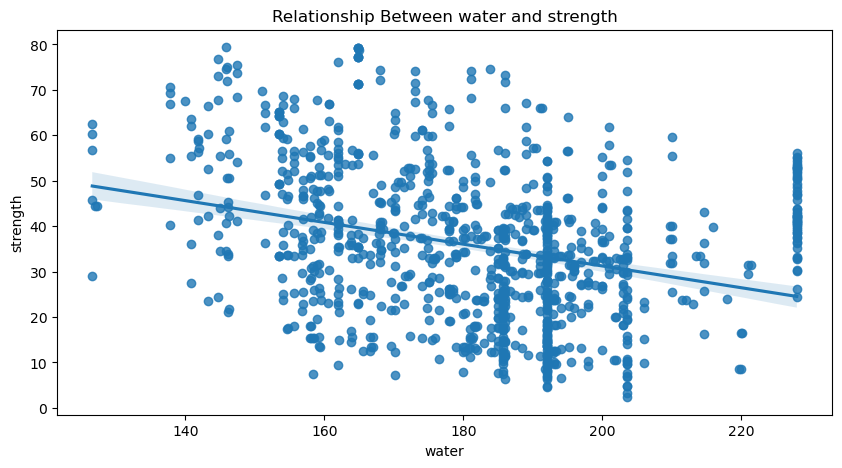

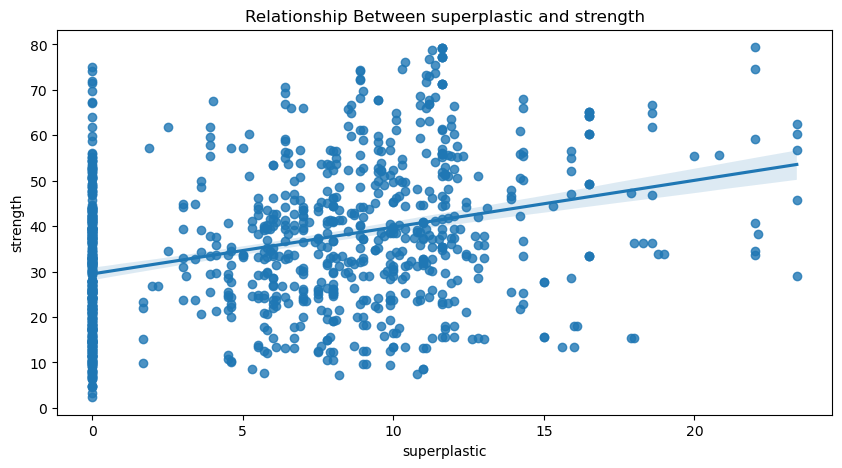

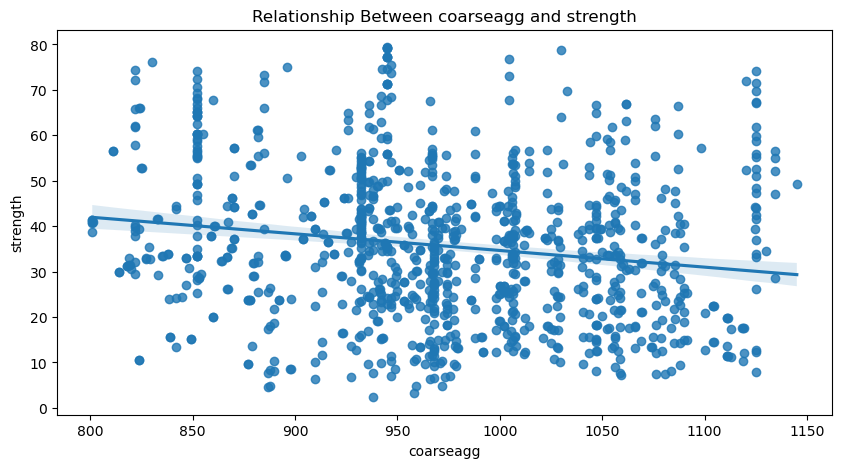

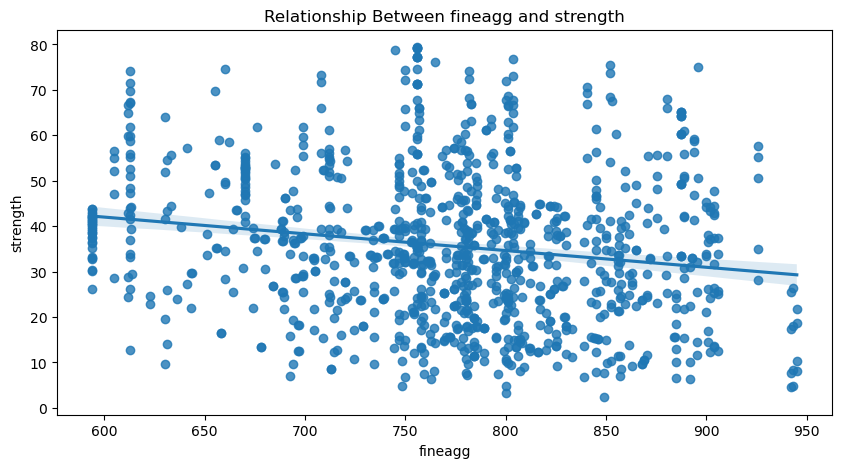

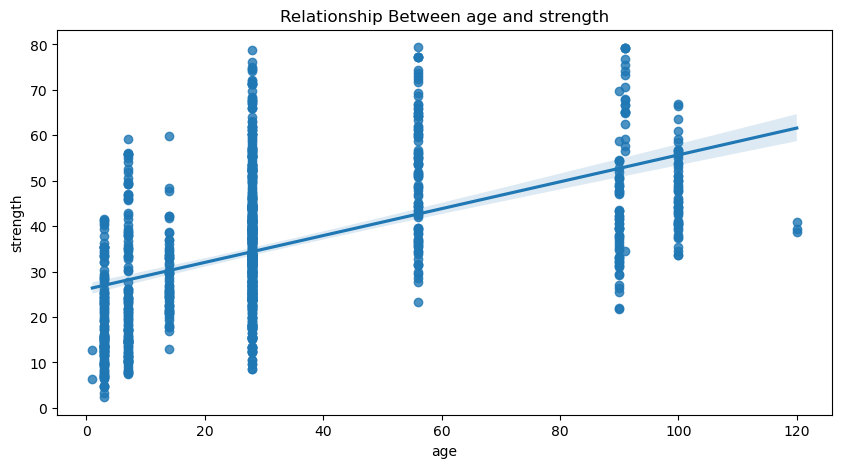

In [31]:
for col in df.columns:
    if col != 'strength':
        fig,ax1 = plt.subplots(figsize = (10,5))
        sns.regplot(x = df[col], y = df['strength'], ax = ax1).set_title(f'Relationship Between {col} and strength')
        

Multicollinearity Test

<Axes: >

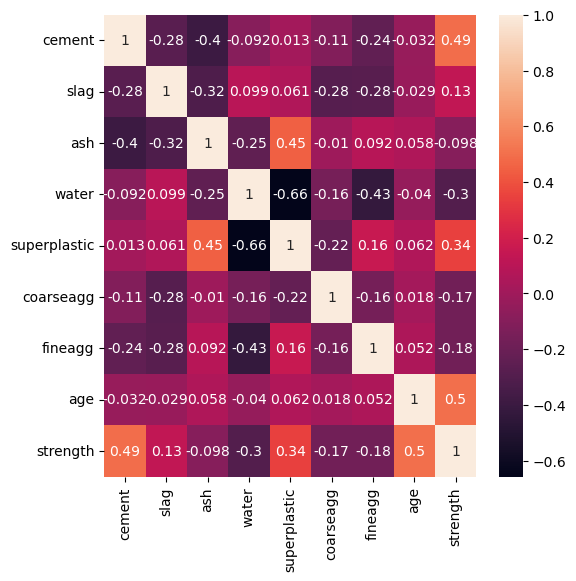

In [38]:
corr = df.corr()
df.ax = plt.subplots(figsize = (6,6))
sns.heatmap(corr, annot = True)

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [42]:
def calculate_vif(dataset):
    vif = pd.DataFrame()
    vif['features'] = dataset.columns
    vif['VIF_Values'] = [variance_inflation_factor(dataset.values,i) for i in range(dataset.shape[1])]
    vif['VIF_Values'] = round(vif['VIF_Values'], 2)
    vif = vif.sort_values(by = 'VIF_Values', ascending = False)
    return vif

In [44]:
calculate_vif(df.drop('strength', axis = 1))

features  VIF_Values
5     coarseagg       86.94
3         water       81.96
6       fineagg       68.66
0        cement       14.29
4  superplastic        5.72
2           ash        4.42
1          slag        3.34
7           age        2.37

Correlation with the target feature

In [47]:
def correlation_with_target(data, t_col):
    independent_variable = data.drop(t_col, axis = 1).columns
    corr_result = []
    for col in independent_variable:
        corr_result.append(data[t_col].corr(data[col]))
    result = pd.DataFrame([independent_variable, corr_result], index = ['Independent Variables', 'correlation']).T
    return result.sort_values('correlation', ascending = False)

In [49]:
correlation_with_target(df, 'strength')

Independent Variables correlation
7                   age    0.499711
0                cement    0.493518
4          superplastic    0.342633
1                  slag    0.129561
2                   ash   -0.097973
5             coarseagg   -0.173234
6               fineagg   -0.176113
3                 water   -0.300043

Applying PCA to treat Multicollinearity 

In [52]:
def custom_PCA(X):
    n_comp = len(X.columns)
    
    #Applying StandardScaler for Feature scaling
    
    sc = StandardScaler()
    X = sc.fit_transform(X)
    
    
    for i in range(1,n_comp):
        pca = PCA(n_components=i)
        p_comp = pca.fit_transform(X)
        evr = np.cumsum(pca.explained_variance_ratio_)
        if evr[i-1] > 0.9:
            pcs = i
            break
    print('Explained Variance ratio after PCA is:', evr)
    
    #Creating a dataframe of Principle components
    col = []
    for j in range(1, pcs+1):
        col.append('PC_' + str(j))
    pca_df = pd.DataFrame(p_comp, columns = col)
    return pca_df

In [54]:
pca_df = custom_PCA(df.drop('strength', axis =1))

Explained Variance ratio after PCA is: [0.27112429 0.44666571 0.60914114 0.73584634 0.85926016 0.97264602]


In [56]:
pca_df.head()

PC_1      PC_2      PC_3      PC_4      PC_5      PC_6
0  1.810919  1.331664 -1.284484 -0.306148 -0.067652 -0.886110
1 -1.823833 -0.573436 -1.058973  0.893130 -0.913984 -0.751061
2 -0.739819 -0.463200 -0.541643 -1.033210 -0.308068  0.611045
3  2.766368  0.602978 -0.512532  0.008806  0.086415  0.850548
4  0.892523  0.966627 -0.863624  1.148561 -0.064439 -1.221228

Joining PCA Features with Target Features

In [59]:
calculate_vif(pca_df)

features  VIF_Values
0     PC_1         1.0
1     PC_2         1.0
2     PC_3         1.0
3     PC_4         1.0
4     PC_5         1.0
5     PC_6         1.0

In [61]:
pca_df = pca_df.join(df['strength'], how = 'left')

In [63]:
pca_df.head()

PC_1      PC_2      PC_3      PC_4      PC_5      PC_6  strength
0  1.810919  1.331664 -1.284484 -0.306148 -0.067652 -0.886110     29.89
1 -1.823833 -0.573436 -1.058973  0.893130 -0.913984 -0.751061     23.51
2 -0.739819 -0.463200 -0.541643 -1.033210 -0.308068  0.611045     29.22
3  2.766368  0.602978 -0.512532  0.008806  0.086415  0.850548     45.85
4  0.892523  0.966627 -0.863624  1.148561 -0.064439 -1.221228     18.29

 Model Building 

In [66]:
def train_and_test_split(data, tcol, testSize = 0.3, randomState = 3):
    X = data.drop(tcol, axis = 1)
    y = data[tcol]
    return train_test_split(X,y,test_size = testSize, random_state = randomState)

In [68]:
def model_builder(model_name, model, data, t_col):
    X_train, X_test, y_train, y_test = train_and_test_split(data, t_col)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    result = [model_name, rmse, r2]
    return result

In [70]:
model_builder(model_name = 'LinearRegression', model = LinearRegression(), data = pca_df, t_col = 'strength')

['LinearRegression', 9.098029413143959, 0.7005612990763813]

In [72]:
model_builder(model_name = 'Lasso', model = Lasso(), data = pca_df, t_col = 'strength')

['Lasso', 9.494111755120294, 0.6739216716616949]

In [74]:
col_names = ['Model Name', 'RMSE', 'R2 Score']
result = pd.DataFrame(columns = col_names)
len(result)

0

In [76]:
result.loc[len(result)] = model_builder('Linear Regression', LinearRegression(), pca_df , 'strength')

In [78]:
result

Model Name      RMSE  R2 Score
0  Linear Regression  9.098029  0.700561

In [80]:
len(result)

1

In [82]:
result.loc[len(result)] = model_builder('Lasso', Lasso(), pca_df , 'strength')

In [84]:
result

Model Name      RMSE  R2 Score
0  Linear Regression  9.098029  0.700561
1              Lasso  9.494112  0.673922

In [86]:
len(result)

2

In [88]:
result.loc[len(result)] = model_builder('Ridge', Ridge(), pca_df , 'strength')

In [90]:
result

Model Name      RMSE  R2 Score
0  Linear Regression  9.098029  0.700561
1              Lasso  9.494112  0.673922
2              Ridge  9.099976  0.700433

In [92]:
len(result)

3

In [94]:
def multiple_models(data, t_col):
    col_names = ['Model Name', 'RMSE', 'R2 Score']
    result = pd.DataFrame(columns = col_names)
    result.loc[len(result)] = model_builder('Linear Regression', LinearRegression(), data , t_col)
    result.loc[len(result)] = model_builder('Lasso', Lasso(), data , t_col)
    result.loc[len(result)] = model_builder('Ridge', Ridge(), data , t_col)
    result.loc[len(result)] = model_builder('DTR', DecisionTreeRegressor(), data , t_col)
    result.loc[len(result)] = model_builder('SVR', SVR(), data , t_col)
    result.loc[len(result)] = model_builder('Random Forest', RandomForestRegressor(), data , t_col)
    result.loc[len(result)] = model_builder('KNN',KNeighborsRegressor(), data , t_col)
    result.loc[len(result)] = model_builder('Gboost',GradientBoostingRegressor(), data , t_col)
    result.loc[len(result)] = model_builder('XGboost',XGBRegressor(), data , t_col)
    result.loc[len(result)] = model_builder('Adaboost',AdaBoostRegressor(), data , t_col)
    return result.sort_values('R2 Score', ascending = False)

In [96]:
multiple_models(pca_df,'strength')

Model Name      RMSE  R2 Score
8            XGboost  5.903539  0.873922
5      Random Forest  6.363895  0.853493
7             Gboost  6.675798  0.838780
6                KNN  7.799392  0.779943
9           Adaboost  8.781225  0.721052
3                DTR  9.079152  0.701803
0  Linear Regression  9.098029  0.700561
2              Ridge  9.099976  0.700433
4                SVR  9.123982  0.698851
1              Lasso  9.494112  0.673922

In [98]:
def k_fold_cv(X,y,fold = 10):
    score_LR = cross_val_score(LinearRegression(), X,y, cv = fold)
    score_LS = cross_val_score(Lasso(), X,y, cv = fold)
    score_RD = cross_val_score(Ridge(), X, y, cv = fold)
    score_DTR = cross_val_score(DecisionTreeRegressor(), X, y , cv = fold)
    score_SVR = cross_val_score(SVR(), X, y, cv = fold)
    score_RandomForest = cross_val_score(RandomForestRegressor(), X,y, cv = fold)
    score_KNN = cross_val_score(KNeighborsRegressor(), X,y , cv = fold)
    score_GBoost = cross_val_score(GradientBoostingRegressor(), X, y, cv = fold)
    score_XGBoost = cross_val_score(XGBRegressor(), X,y,cv = fold)
    score_AdaBoost = cross_val_score(AdaBoostRegressor(), X, y, cv = fold)
    
    
    
    model_name = ['Linear Regression', 'Lasso', 'Ridge', 'DecisionTreeRegressor', 'SVR', 'Random Forest',
                 'KNN', 'GBoost', 'XGboost', 'AdaBoost']
    scores = [score_LR, score_LS, score_RD, score_DTR, score_SVR, score_RandomForest, score_KNN, score_GBoost,
            score_XGBoost,score_AdaBoost]
    result = []
    for i in range(len(model_name)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_name = model_name[i]
        temp = [m_name,score_mean, score_std]
        result.append(temp)
    k_fold_df = pd.DataFrame(result, columns = ['Model Name', 'CV Accuracy', 'CV STD'])
    return k_fold_df.sort_values('CV Accuracy', ascending = False)

In [100]:
k_fold_cv(pca_df.drop('strength', axis =1), pca_df['strength'])

Model Name  CV Accuracy    CV STD
8                XGboost     0.871087  0.045670
5          Random Forest     0.866532  0.031791
7                 GBoost     0.829387  0.050135
6                    KNN     0.768315  0.056046
3  DecisionTreeRegressor     0.758881  0.062399
9               AdaBoost     0.728412  0.034185
4                    SVR     0.703117  0.042765
2                  Ridge     0.663935  0.059437
0      Linear Regression     0.663928  0.059476
1                  Lasso     0.649837  0.049887

Hyperparameter tuning

In [103]:
def tuning(X,y,fold = 10):
    #generally we dont do for all the models, we do for top 5 best performing models.
    param_LAS = {'alpha' : [1e-15,1e-13, 1e-11, 1e-9, 1e-7, 1e-5,1e-3, 1e-1, 0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500]}
    param_KNN = {'n_neighbors' : [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]}
    param_DTR = {'max_depth' : [3,5,7,9,10,12,14,16]}
    param_SVR = {'gamma': ['scale', 'auto'], 'C' : [0.5,1]}
    param_ADB = {'learning_rate' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_GB = {'alpha' : [0.1,0.2,0.3,0.4,0.5] }
    param_XGB = {'eta' : [0.1,0.2,0.3,0.4,0.5], 'max_depth' : [3,5,7,9,10,12,14,15,16],'gamma': [10,20,30,40,50,60,70,80,90,100,200,300,400,500], 'reg_lambda' : [0,1] }
    param_RF = {'max_depth' : [3,5,7,8,9,10,12,14,16], 'max_features' : ['auto', 'log2', 'sqrt', 2,3,4,5,6]}
    
    
    #Hyperparameter tuning
    tune_LAS = GridSearchCV(Lasso(), param_LAS, cv = fold)
    tune_RID = GridSearchCV(Ridge(), param_LAS, cv = fold)
    tune_KNN = GridSearchCV(KNeighborsRegressor(), param_KNN, cv = fold)
    tune_DT = GridSearchCV(DecisionTreeRegressor(), param_DTR, cv = fold)
    tune_SVR = GridSearchCV(SVR(), param_SVR, cv = fold)
    tune_ADB =  GridSearchCV(AdaBoostRegressor(),param_ADB, cv = fold)
    tune_GB =  GridSearchCV(GradientBoostingRegressor(),param_ADB, cv = fold)
    tune_XGB =  GridSearchCV(XGBRegressor(),param_ADB, cv = fold)
    tune_RF = GridSearchCV(RandomForestRegressor(),param_RF, cv = fold)
    
    #Fitting X and Y
    tune_LAS.fit(X,y)
    tune_RID.fit(X,y)
    tune_KNN.fit(X,y)
    tune_DT.fit(X,y)
    tune_SVR.fit(X,y)
    tune_ADB.fit(X,y)
    tune_GB.fit(X,y)
    tune_XGB.fit(X,y)
    tune_RF.fit(X,y)
    
    tune = [tune_LAS,tune_RID,tune_KNN, tune_DT, tune_SVR,tune_ADB,tune_GB, tune_XGB,tune_RF]
    models = ['Lasso', 'Ridge', 'KNN', 'DTR', 'SVR', 'ADBR', 'GBR', 'XGBR', 'RFR']
    
    for i in range(len(tune)):
        print('models:', models[i])
        print('best parameters :', tune[i].best_params_)

Cross-validation post Hyperparameter tuning

In [106]:
def cv_post_hpt(X,y, fold = 10):
    score_LR = cross_val_score(LinearRegression(), X,y, cv = fold)
    score_LS = cross_val_score(Lasso(alpha = 0.1), X,y, cv = fold)
    score_RD = cross_val_score(Ridge(alpha = 0.1), X, y, cv = fold)
    score_DTR = cross_val_score(DecisionTreeRegressor(max_depth = 10), X, y , cv = fold)
    score_SVR = cross_val_score(SVR(C =1, gamma = 'scale'), X, y, cv = fold)
    score_RandomForest = cross_val_score(RandomForestRegressor(max_depth = 14, max_features =3), X,y, cv = fold)
    score_KNN = cross_val_score(KNeighborsRegressor(n_neighbors = 4), X,y , cv = fold)
    score_GBoost = cross_val_score(GradientBoostingRegressor(learning_rate = 0.3), X, y, cv = fold)
    score_XGBoost = cross_val_score(XGBRegressor(learning_rate = 0.3), X,y,cv = fold)
    score_AdaBoost = cross_val_score(AdaBoostRegressor(learning_rate = 1), X, y, cv = fold)
    
    
    
    model_name = ['Linear Regression', 'Lasso', 'Ridge', 'DecisionTreeRegressor', 'SVR', 'Random Forest',
                 'KNN', 'GBoost', 'XGboost', 'AdaBoost']
    scores = [score_LR, score_LS, score_RD, score_DTR, score_SVR, score_RandomForest, score_KNN, score_GBoost,
            score_XGBoost,score_AdaBoost]
    result = []
    for i in range(len(model_name)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_name = model_name[i]
        temp = [m_name,score_mean, score_std]
        result.append(temp)
    k_fold_df = pd.DataFrame(result, columns = ['Model Name', 'CV Accuracy', 'CV STD'])
    return k_fold_df.sort_values('CV Accuracy', ascending = False)

In [108]:
cv_post_hpt(pca_df.drop('strength', axis =1), pca_df['strength'])

Model Name  CV Accuracy    CV STD
8                XGboost     0.871087  0.045670
5          Random Forest     0.867300  0.032124
7                 GBoost     0.857109  0.049194
6                    KNN     0.770907  0.054610
3  DecisionTreeRegressor     0.762799  0.050372
9               AdaBoost     0.727451  0.042218
4                    SVR     0.703117  0.042765
1                  Lasso     0.664143  0.058426
2                  Ridge     0.663928  0.059472
0      Linear Regression     0.663928  0.059476

Clustering

In [111]:
pca_df.head()

PC_1      PC_2      PC_3      PC_4      PC_5      PC_6  strength
0  1.810919  1.331664 -1.284484 -0.306148 -0.067652 -0.886110     29.89
1 -1.823833 -0.573436 -1.058973  0.893130 -0.913984 -0.751061     23.51
2 -0.739819 -0.463200 -0.541643 -1.033210 -0.308068  0.611045     29.22
3  2.766368  0.602978 -0.512532  0.008806  0.086415  0.850548     45.85
4  0.892523  0.966627 -0.863624  1.148561 -0.064439 -1.221228     18.29

<Axes: xlabel='cement', ylabel='strength'>

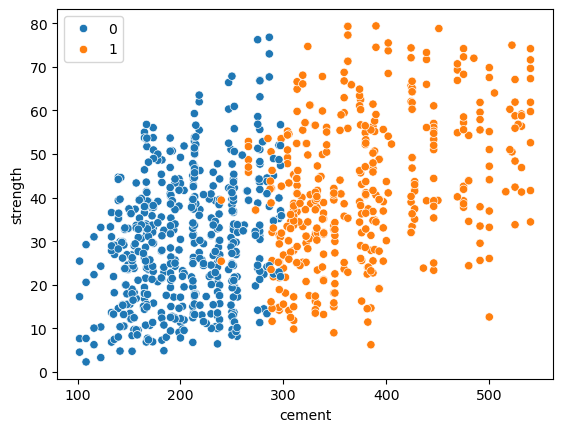

In [113]:
kmeans = KMeans(n_clusters =2, random_state = 2)
clusters = kmeans.fit_predict(df.drop('strength', axis = 1))
sns.scatterplot(x = df['cement'], y = df['strength'], hue = clusters)

In [115]:
df.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   

   strength  
0     29.89  
1     23.51  
2     29.22  
3     45.85  
4     18.29

In [117]:
def clustering(X, tcol, clusters):
    column = list(set(list(X.columns)) - set(X['strength']))
    r = int(len(column) / 2)
    if r % 2 == 0:
        r = r
    else:
        r += 1
    
    f,ax = plt.subplots(r,2, figsize = (15,15))
    a = 0
    for row in range(r):
        for col in range(0,2):
            if a!= len(column):
                ax[row][col].scatter(X[tcol], X[column[a]], c = clusters)
                ax[row][col].set_xlabel(tcol)
                ax[row][col].set_ylabel(column[a])
                a +=1

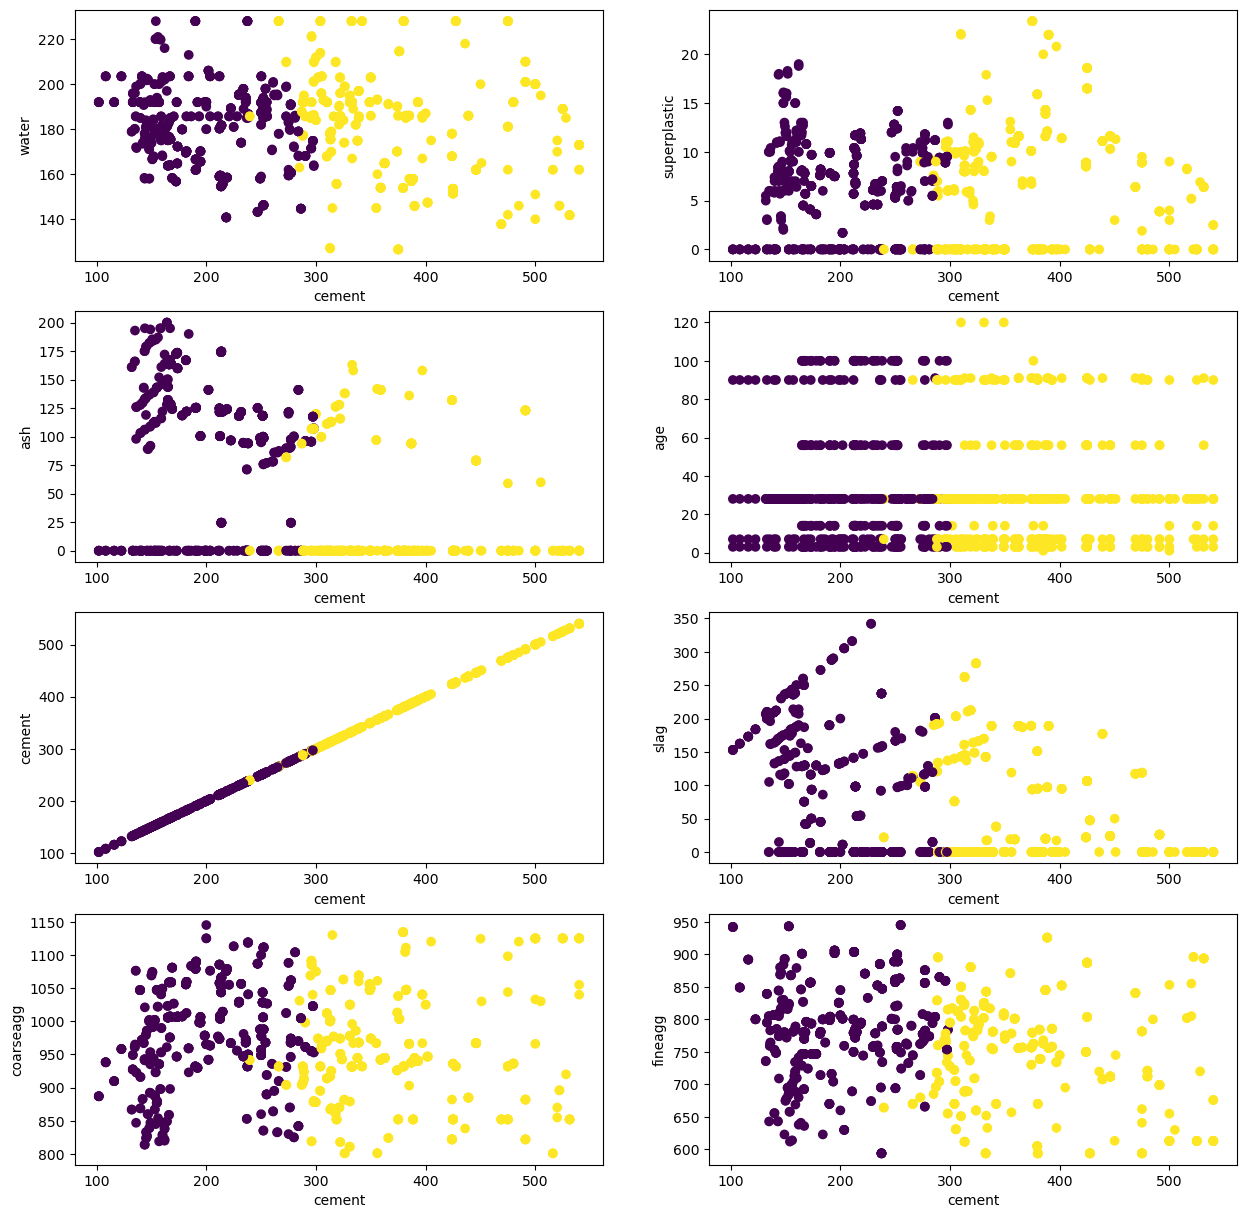

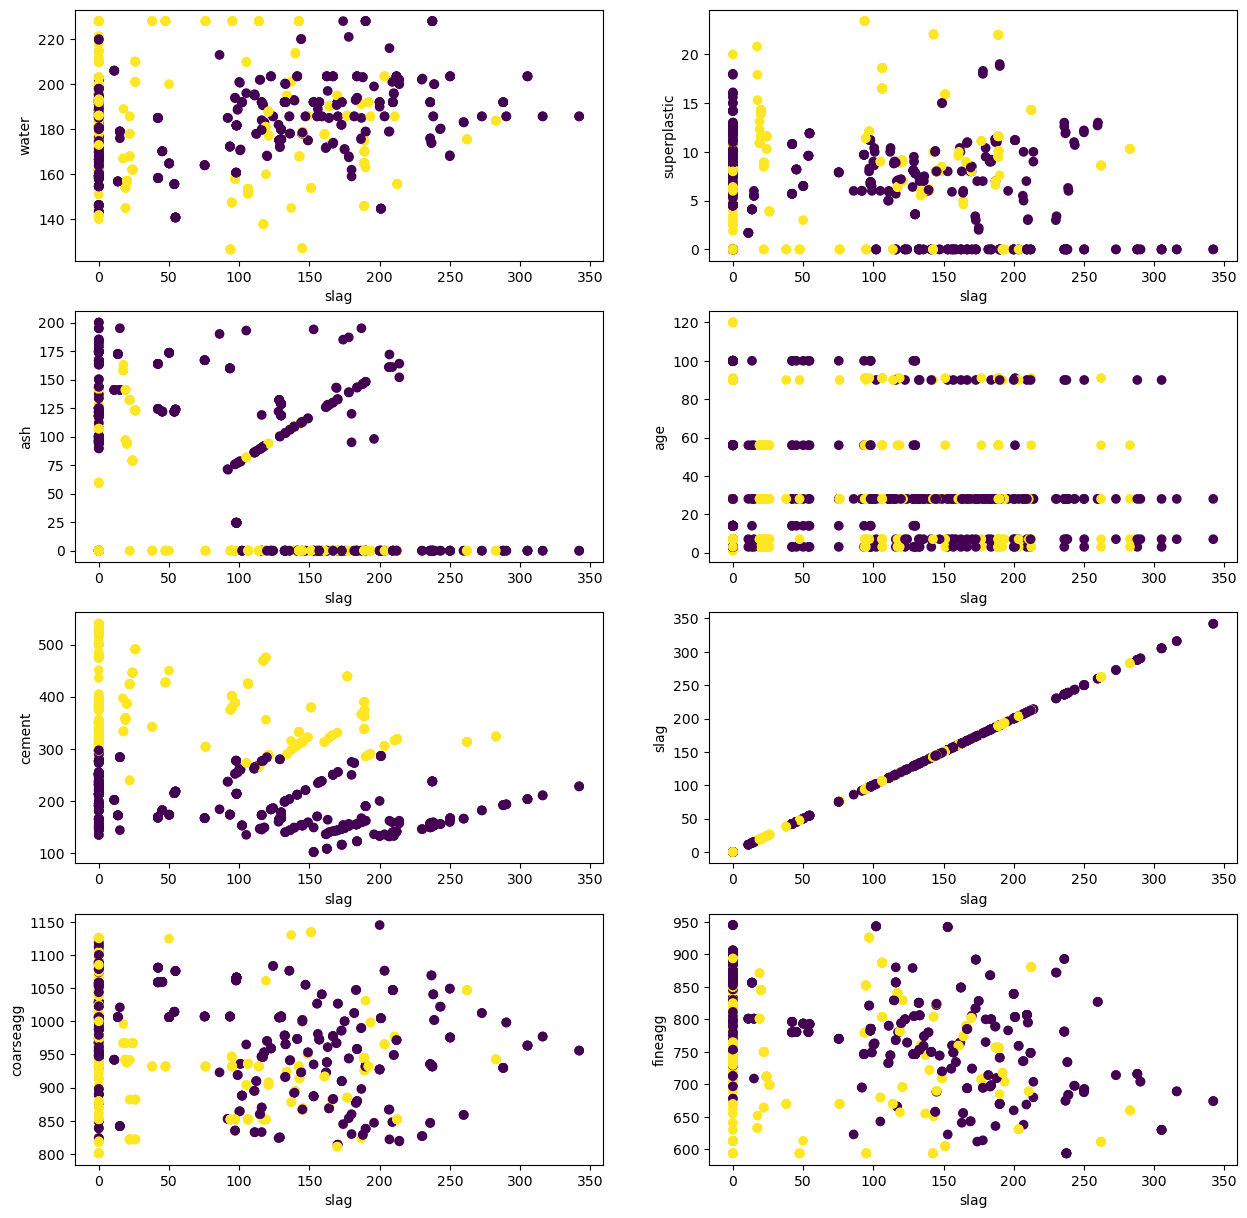

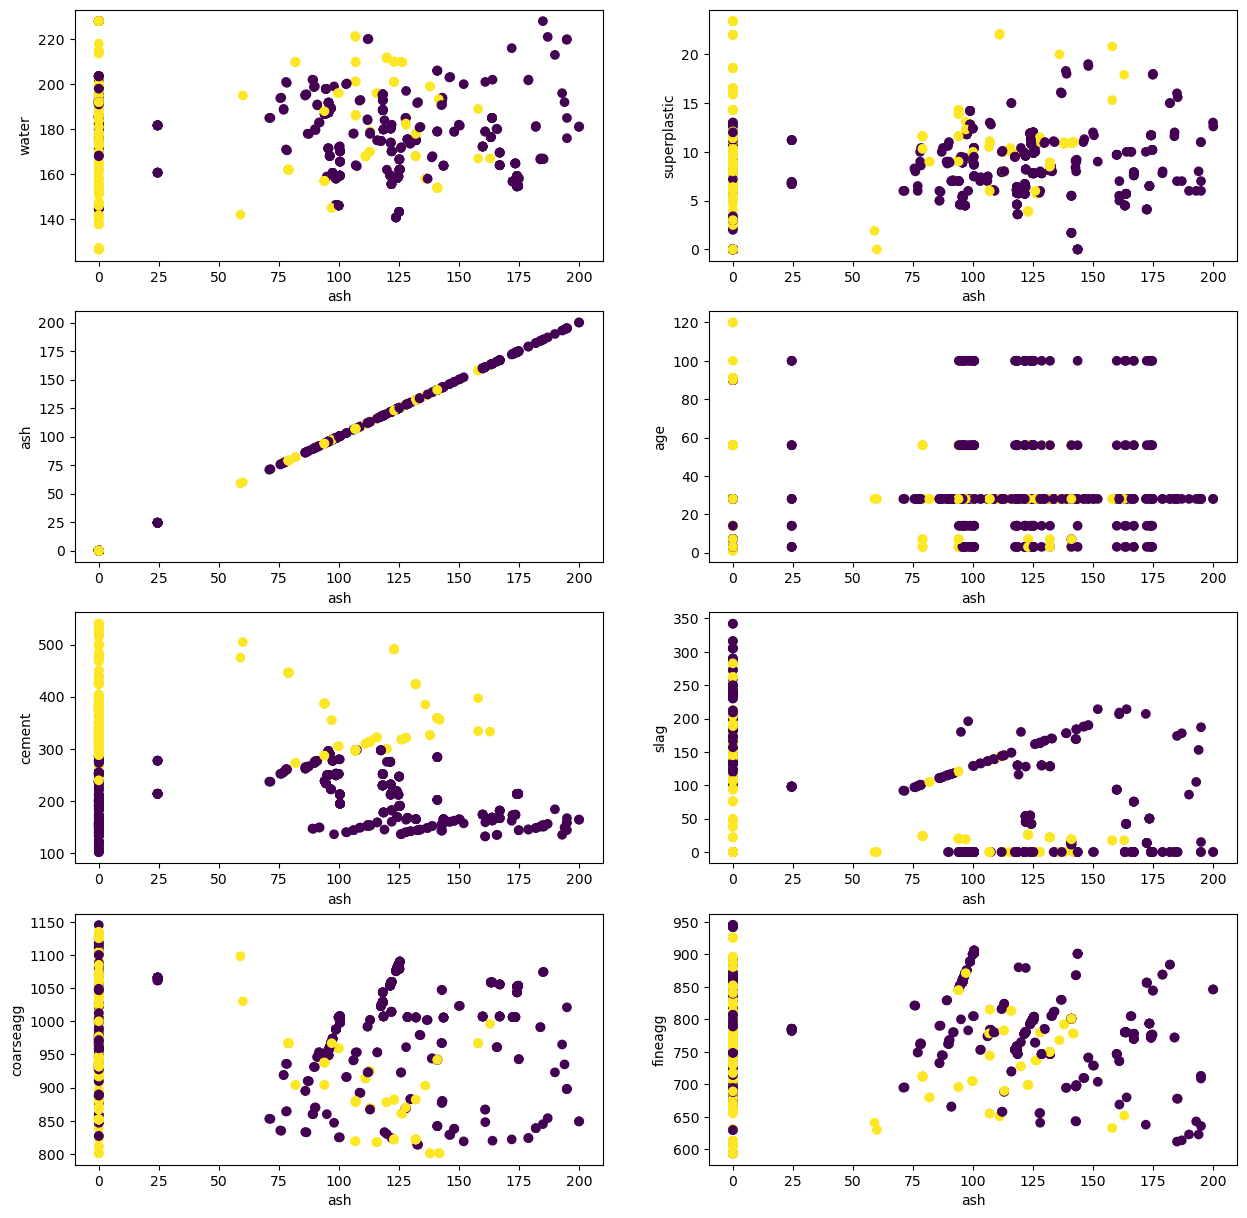

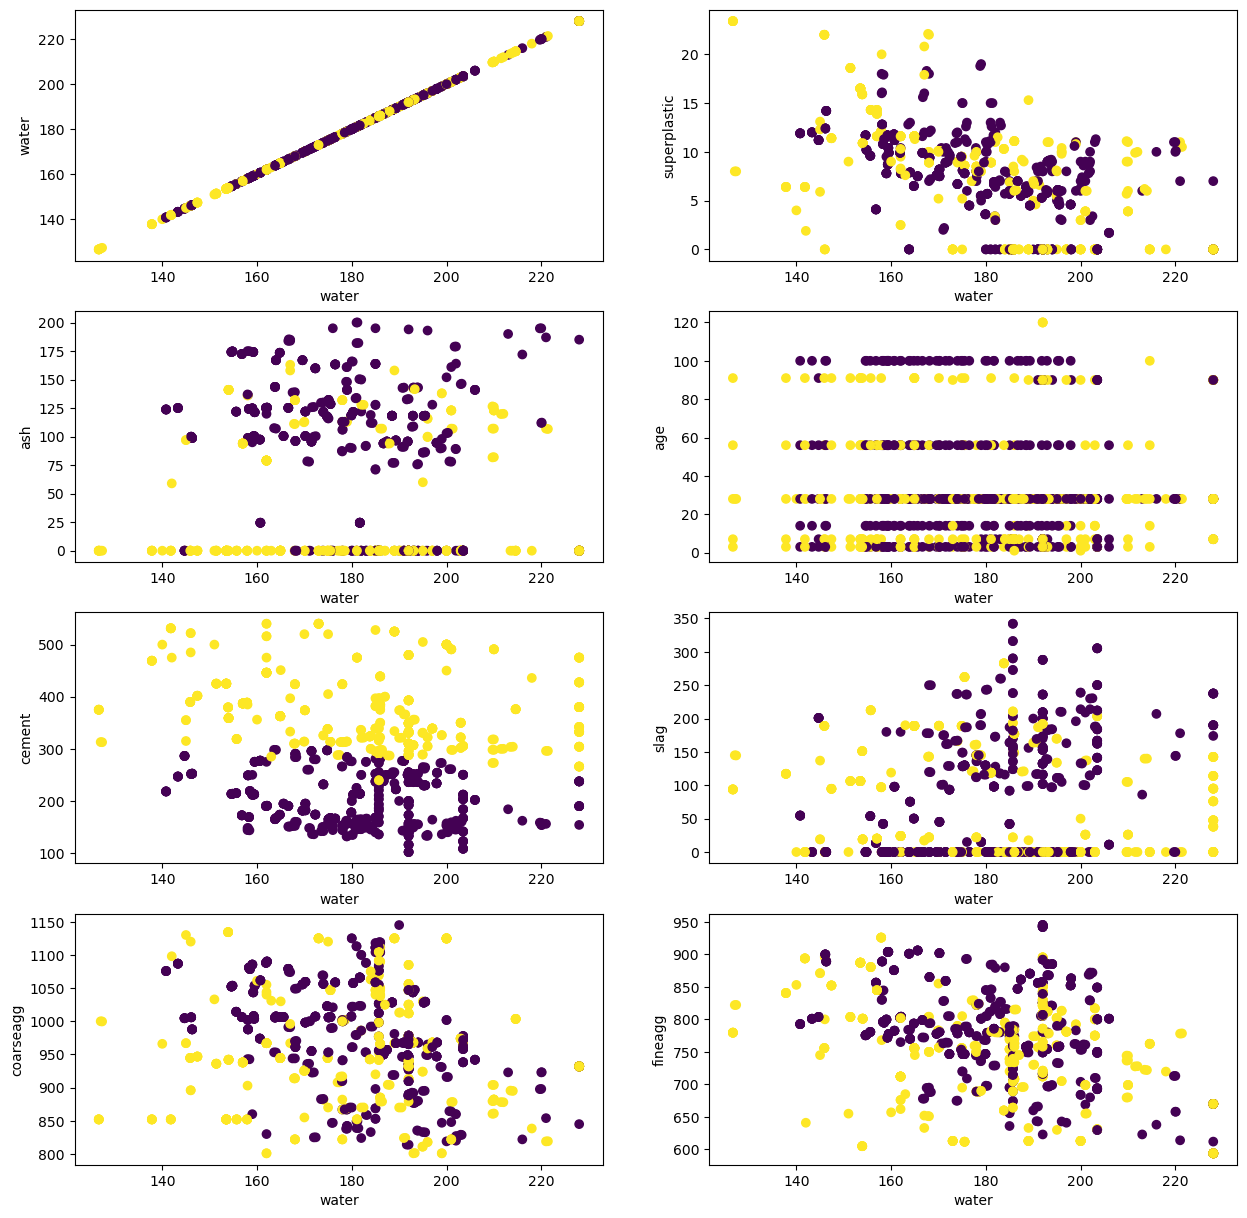

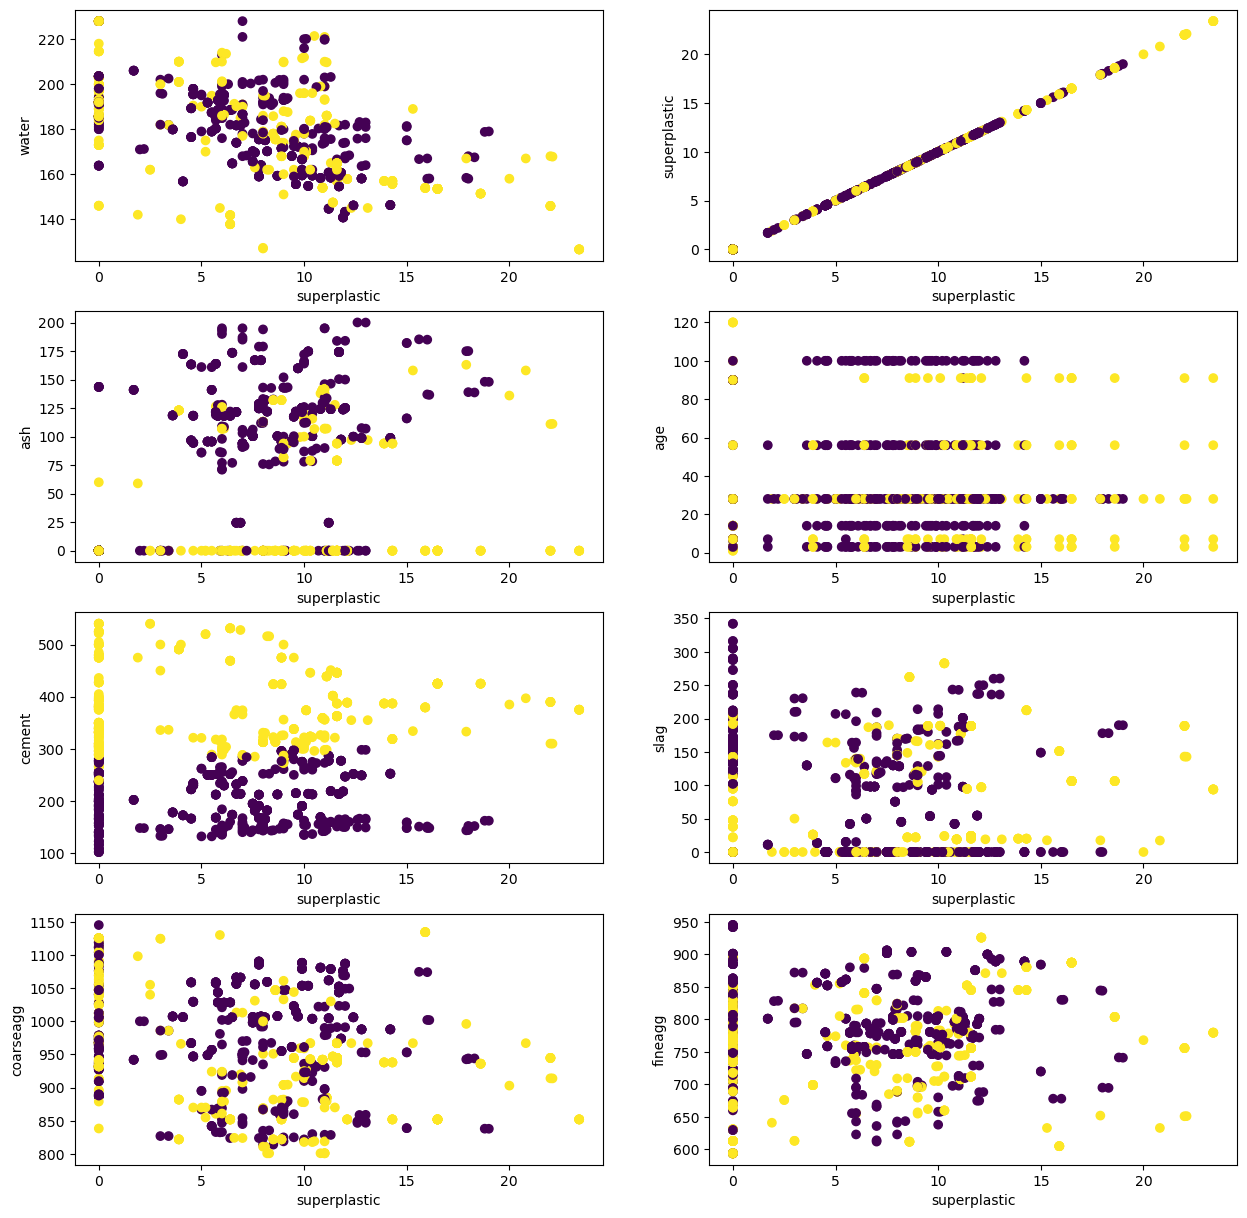

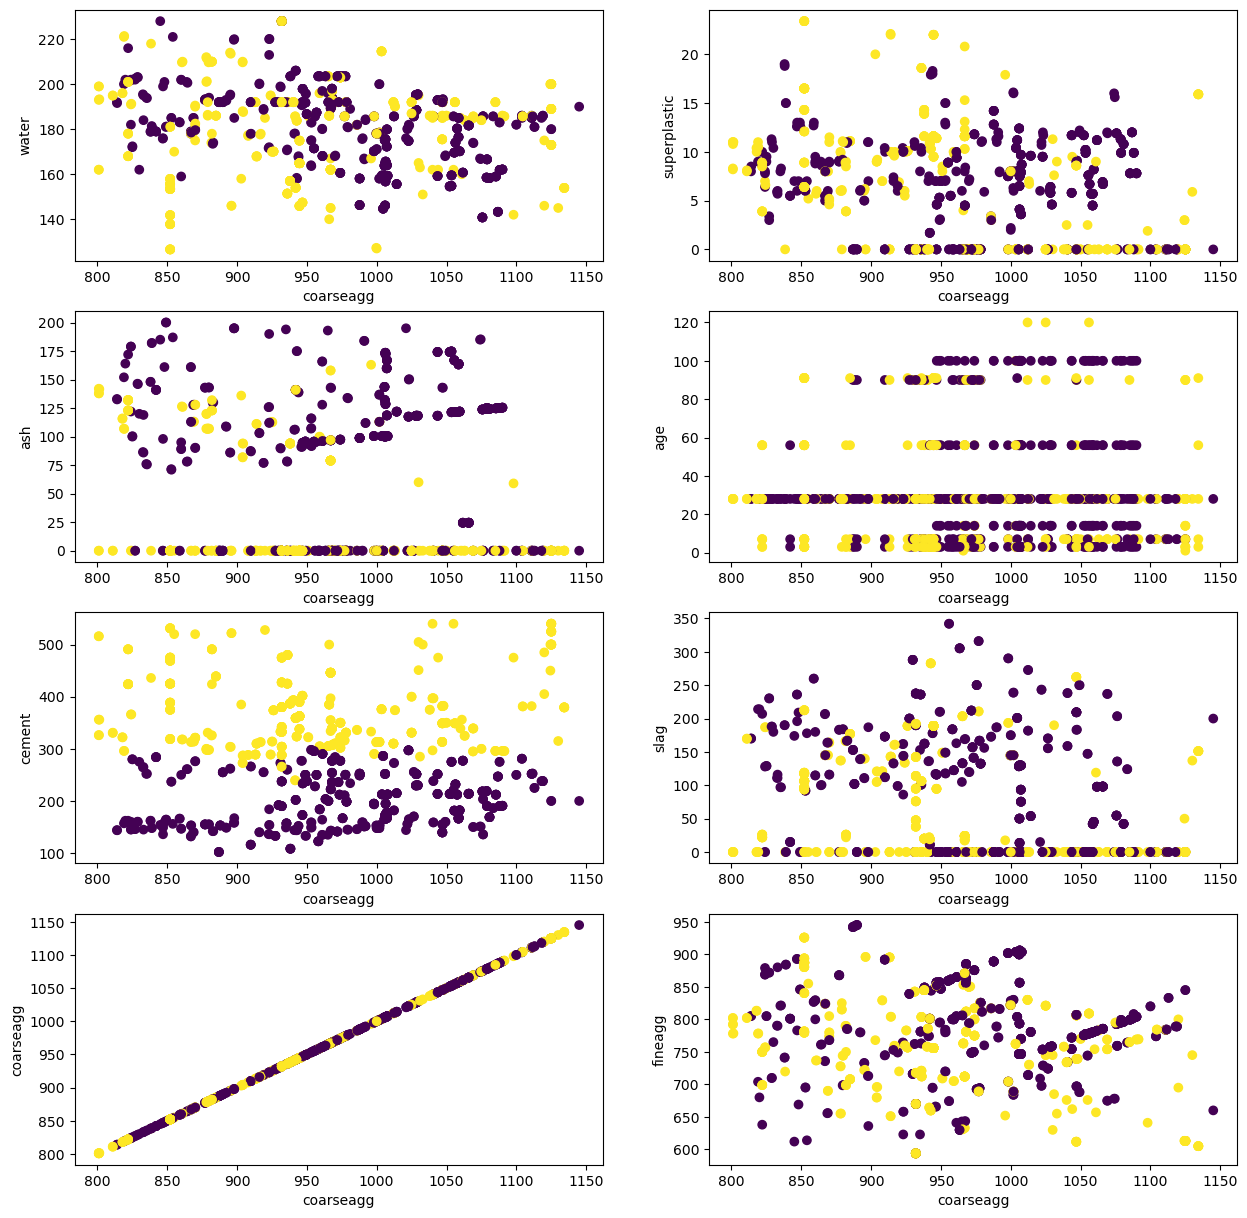

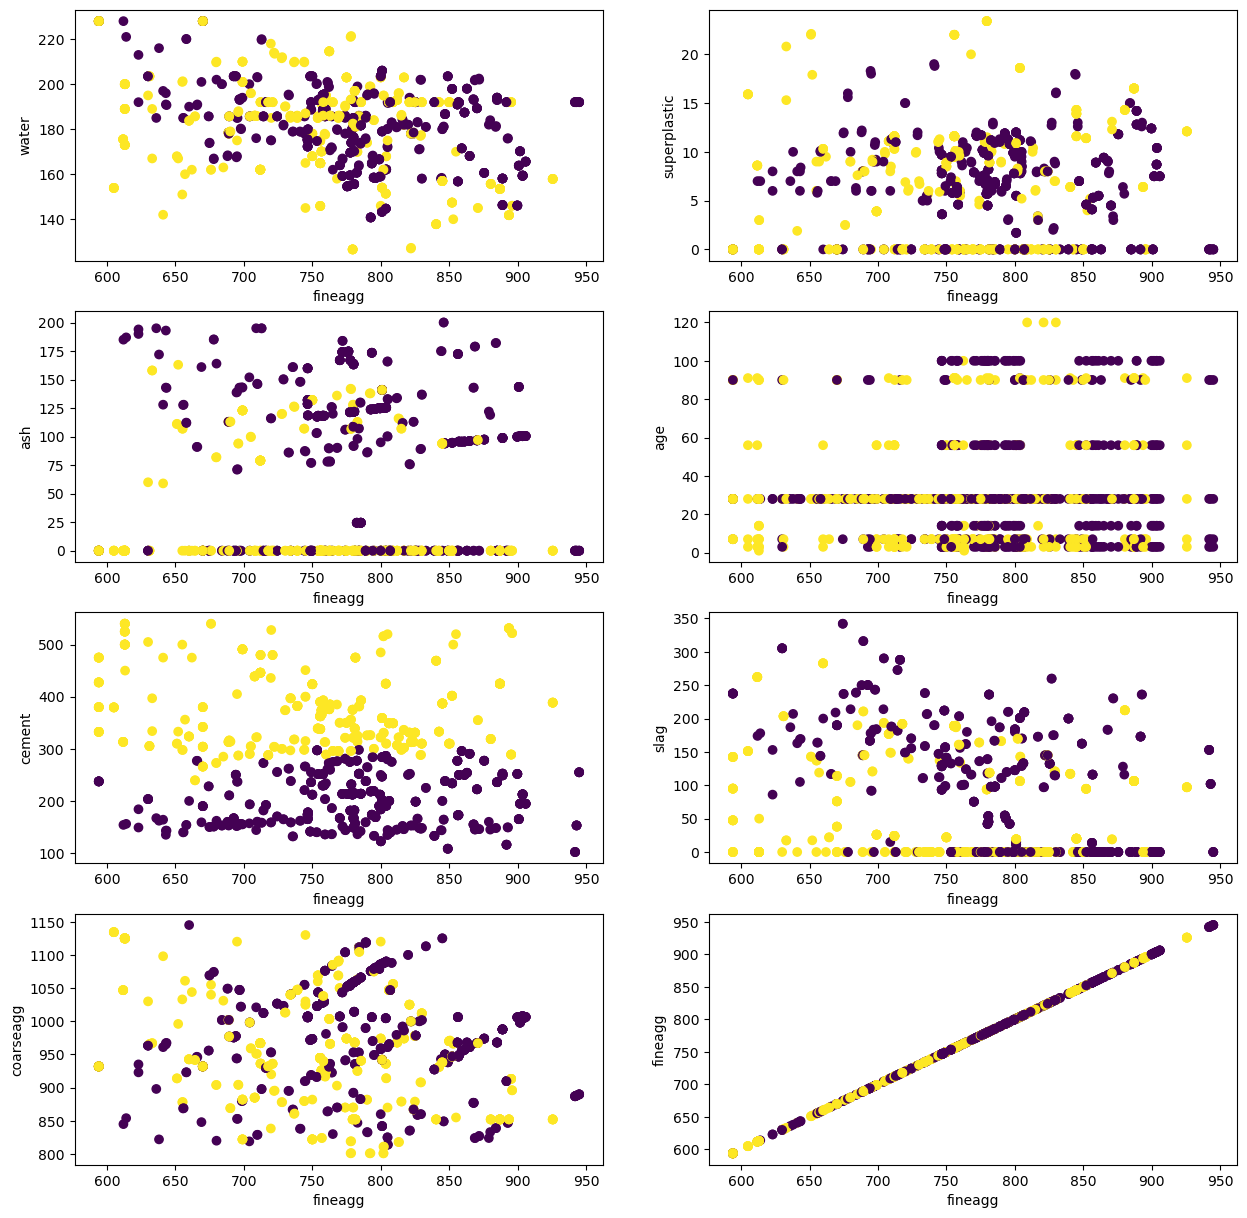

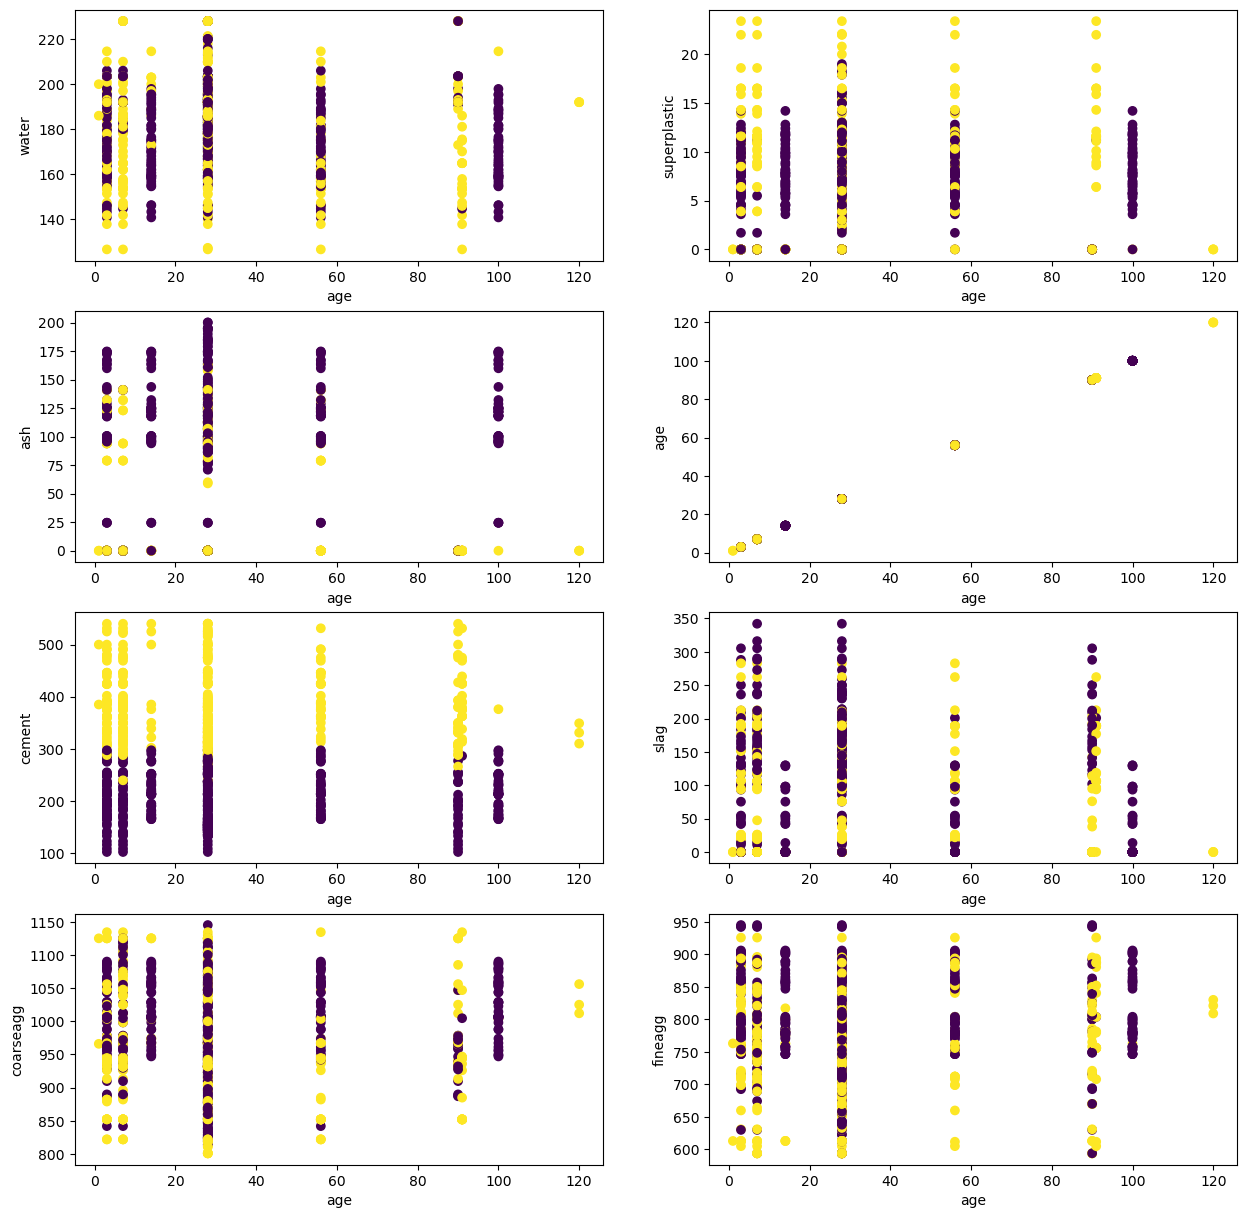

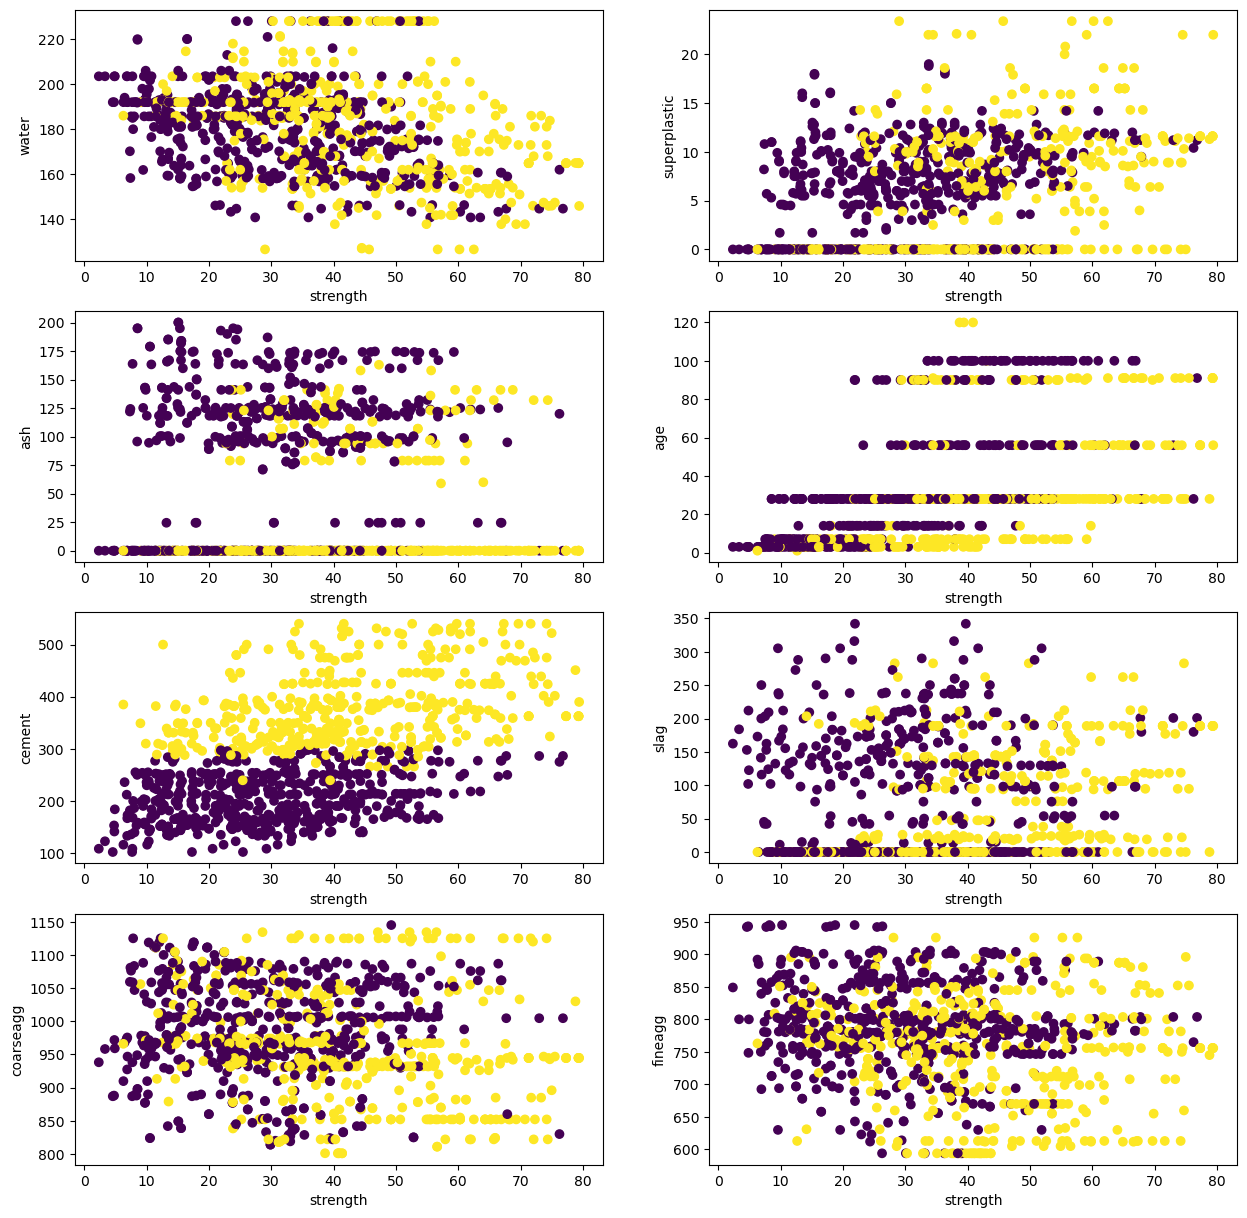

In [119]:
X = df.drop('strength', axis = 1)
for col in df.columns:
    clustering(df,col,clusters)

In [121]:
new_df = df.join(pd.DataFrame(clusters,  columns = ['clusters']), how = 'left')
new_df.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   

   strength  clusters  
0     29.89         0  
1     23.51         0  
2     29.22         0  
3     45.85         1  
4     18.29         0

In [123]:
new_df.clusters.value_counts()

clusters
0    569
1    461
Name: count, dtype: int64

In [125]:
clusters_agg = new_df.groupby('clusters')['cement'].agg(['mean', 'median'])
clusters_agg

mean  median
clusters                    
0         203.417047   202.0
1         377.133623   362.6

In [127]:
clusters_df = new_df.merge(clusters_agg, on = 'clusters', how = 'left')
clusters_df.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   

   strength  clusters        mean  median  
0     29.89         0  203.417047   202.0  
1     23.51         0  203.417047   202.0  
2     29.22         0  203.417047   202.0  
3     45.85         1  377.133623   362.6  
4     18.29         0  203.417047   202.0

In [129]:
multiple_models(clusters_df.drop('clusters', axis =1),'strength')

Model Name       RMSE  R2 Score
8            XGboost   5.278942  0.899189
5      Random Forest   5.646111  0.884678
7             Gboost   5.863647  0.875620
3                DTR   6.844337  0.830537
9           Adaboost   8.274072  0.752342
0  Linear Regression   8.782402  0.720977
2              Ridge   8.782405  0.720977
1              Lasso   8.796944  0.720052
6                KNN   9.983340  0.639450
4                SVR  14.325031  0.257657

In [131]:
X = clusters_df.drop(['strength', 'clusters'], axis = 1)
y = clusters-df['strength']
k_fold_cv(X,y)

Model Name  CV Accuracy    CV STD
8                XGboost     0.895191  0.038297
5          Random Forest     0.884717  0.035701
7                 GBoost     0.873495  0.048151
3  DecisionTreeRegressor     0.820745  0.053075
9               AdaBoost     0.738232  0.044230
0      Linear Regression     0.679497  0.063476
2                  Ridge     0.679421  0.063478
1                  Lasso     0.679176  0.063601
6                    KNN     0.660996  0.089858
4                    SVR     0.229933  0.043871

In [133]:
cv_post_hpt(X,y)

Model Name  CV Accuracy    CV STD
8                XGboost     0.895191  0.038297
5          Random Forest     0.888014  0.033850
7                 GBoost     0.880771  0.059845
3  DecisionTreeRegressor     0.819936  0.060802
9               AdaBoost     0.740536  0.039943
0      Linear Regression     0.679497  0.063476
1                  Lasso     0.679422  0.063486
2                  Ridge     0.679421  0.063478
6                    KNN     0.672262  0.080896
4                    SVR     0.229933  0.043871

Understanding Feature importance using XGBoost

In [136]:
x_train, x_test, y_train, y_test = train_and_test_split(clusters_df.drop(['clusters'], axis = 1), 'strength')

In [138]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

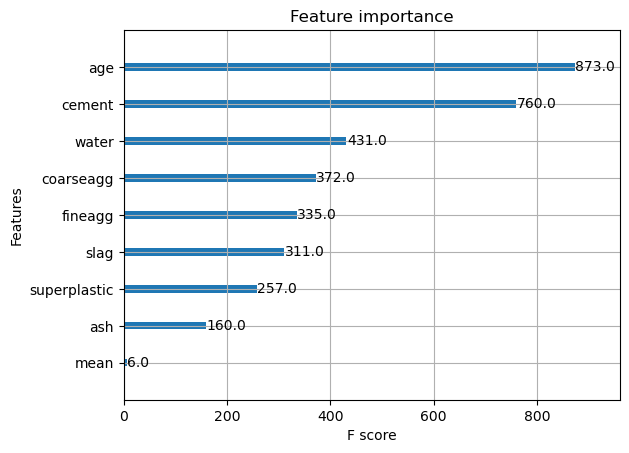

In [140]:
xgboost.plot_importance(xgb)

In [142]:
imp_features = clusters_df[['age', 'cement', 'water', 'coarseagg', 'fineagg', 'strength']]


In [144]:
cv_post_hpt(imp_features.drop('strength', axis =1), imp_features['strength'])

Model Name  CV Accuracy    CV STD
8                XGboost     0.882920  0.039719
5          Random Forest     0.870053  0.031013
7                 GBoost     0.869829  0.050835
3  DecisionTreeRegressor     0.793283  0.082848
9               AdaBoost     0.697071  0.035849
1                  Lasso     0.657583  0.060431
2                  Ridge     0.657579  0.060465
0      Linear Regression     0.657579  0.060465
6                    KNN     0.652519  0.088818
4                    SVR     0.252828  0.044987

Building Learning Curve Analysis


In [147]:
def generate_learning_curve(model_name , estimator , X , y):
    train_size , train_score , test_score = learning_curve(estimator = estimator , X = X , y = y , cv = 10)
    train_score_mean = np.mean(train_score , axis = 1)
    test_score_mean = np.mean(test_score , axis = 1)
    plt.plot(train_size , train_score_mean , c = 'blue')
    plt.plot(train_size , test_score_mean , c = 'red')
    plt.xlabel('Samples')
    plt.ylabel('R2 Score')
    plt.title('Learning Curve for ' + model_name)
    plt.legend(('Training R2 Score' , 'Testing R2 Score'))

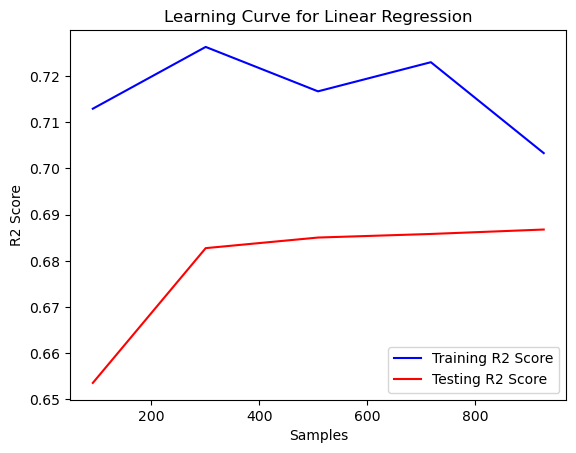

In [149]:
generate_learning_curve('Linear Regression', LinearRegression(), clusters_df.drop(['clusters', 'strength'],axis =1), clusters_df['strength'])

In [ ]:
models = [LinearRegression(), Lasso(), Ridge(), DecisionTreeRegressor(), KNeighborsRegressor(),
         SVR(), RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(),
         XGBRegressor()]
for a, model in enumerate (models):
    fg = plt.figure(figsize = (6,3))
    ax = fig.add_subplot(10,1,a+1)
    generate_learning_curve(type(models[a]).__name__, model, clusters_df.drop(['clusters', 'strength'], axis = 1), clusters_df['strength'])
    